In [897]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import optuna
import joblib

import torch

from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel, LightGBMModel, \
                        CatBoostModel, XGBModel,  BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel
from darts.dataprocessing.transformers import Scaler

from sklearn.svm import SVC
from sklearn.linear_model import PoissonRegressor


from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [898]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [899]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',]

In [900]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [901]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [902]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [903]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [904]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Dengue fever rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Dengue_fever_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [905]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [906]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [907]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y)

In [908]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """

  if is_dl_algo == 1:
    print("🍋")
  else:
    x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
    y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

    x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
    y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

    model.fit(y_train, past_covariates = x_train)

    prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)

    df_eval_true_inverse = df_eval_pred_inverse = df_eval[-args.test_size:]
    y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))

    df_eval_pred_inverse[labels]= np.array(prediction._xa).squeeze()
    y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    df_compare_test_predict.plot()
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mse**0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"mean_squared_error: {mse:.4f}")
    print(f"rmse: {rmse}")
    print(f"mape: {mape}")
    y_true, y_pred, mse, mae, rmse, mape = 0
    return model, y_true, y_pred, mse, mae, rmse, mape


In [909]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo,nstep):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  "1-month": prediction_inverse})
    
    df_prediction["City"] = location
    df_prediction["RMSE_1-month"] = rmse
    df_prediction["MAE_1-month"] = mae
    df_prediction["MAPE_1-month"] = mape

    return mae

In [910]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv", encoding = 'unicode_escape')
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

# Objective and Suggest Hyperparams of Darts Models


In [911]:
def objective(model_name, trial, city, nstep):   
    specific_data = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
    scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok

    df_train, df_valid = split_data(specific_data, args.look_back,nstep)

    selected_features = getDataWithSelectedFeature(city, nstep)

    lags_by_nstep = args.look_back + nstep - 1
    lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
    is_dl_algo = 0

    pl_trainer_kwargs = {
              "accelerator": "cpu",
              # "devices": -1,
              # "auto_select_gpus": True,
          }

    if model_name == "RandomForest":
      random_state = trial.suggest_int('random_state', 0, 42)
      n_estimators = trial.suggest_int('n_estimators', 50, 200)
      max_depth = trial.suggest_int('max_depth', 1, 15)
      # Create the RandomForest model
      model = RandomForest(
                    lags = lags_by_nstep,
                    lags_past_covariates = lags_past_covariates_by_nstep,
                    output_chunk_length = 1,
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    random_state=random_state)
    elif model_name == 'XGBModel':
      random_state = trial.suggest_int('random_state', 0, 43)
      likelihood = trial.suggest_categorical('likelihood', ['quantile'])
      # Create the  model
      model = XGBModel(
                      lags = lags_by_nstep,
                      lags_past_covariates = lags_past_covariates_by_nstep,
                      output_chunk_length = 1,
                      random_state=random_state,
                      likelihood = likelihood
                    )
    elif model_name == 'LinearRegressionModel':
      random_state = trial.suggest_int('random_state', 0, 43)
      # Create the  model
      model = LinearRegressionModel(
                      lags = lags_by_nstep,
                      lags_past_covariates = lags_past_covariates_by_nstep,
                      output_chunk_length = 1,
                      random_state=random_state)
    elif model_name == "CatBoostModel":
      #suggest hyperparams
      learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
      n_estimators = trial.suggest_int('n_estimators', 50, 200)
      max_depth = trial.suggest_int('max_depth', 1, 15)
      random_state = trial.suggest_int('random_state', 0, 1000)
      likelihood = trial.suggest_categorical('likelihood', ['quantile'])
      quantiles =  trial.suggest_categorical('quantiles', [None, [0.1, 0.5, 0.9]])
      bagging_temperature = trial.suggest_float('bagging_temperature', 0.01, 100.0)
      border_count = trial.suggest_int('border_count', 1, 255)
      l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.1, 10)
      random_strength = trial.suggest_float('random_strength', 0.1, 10)
      model = CatBoostModel(
                            lags=lags_by_nstep,
                            lags_past_covariates=lags_past_covariates_by_nstep, 
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth, 
                            output_chunk_length = 1,
                            likelihood = likelihood,
                            quantiles = quantiles,
                            bagging_temperature = bagging_temperature,
                            border_count = border_count,
                            l2_leaf_reg = l2_leaf_reg,
                            random_strength = random_strength,
                            random_state=random_state)
    elif model_name == "LightGBMModel":
      params = {
        "lags": lags_by_nstep,
        "lags_past_covariates": lags_past_covariates_by_nstep,
        "random_state": trial.suggest_int("random_state", 0, 999),
        "multi_models": trial.suggest_categorical("multi_models", [True, False]),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'verbose': -1,
        'likelihood' : trial.suggest_categorical("likelihood", ["quantile"])
      }

      param = params
      model = LightGBMModel(
          lags = param['lags'],
          lags_past_covariates = param['lags_past_covariates'],
          output_chunk_length = 1,
          random_state = param['random_state'],
          multi_models = param['multi_models'],
          likelihood = param['likelihood'],
          num_leaves = param['num_leaves'],
          learning_rate = param['learning_rate'],
          feature_fraction = param['feature_fraction'],
          bagging_fraction = param['bagging_fraction'],
          min_child_samples = param['min_child_samples'],
          lambda_l1 = param['lambda_l1'],
          verbose = param['verbose']
      )
    elif model_name == "SVMRBF":
      random_state = trial.suggest_int('random_state', 0, 42)
      model = SVC(
          random_state = random_state,
          kernel = 'rbf',
          probability=True
      )
    elif model_name == "PoissonRegressor":
      max_iter = trial.suggest_int('max_iter', 50, 200)
      model = PoissonRegressor(
          max_iter = max_iter,
      )
    elif model_name == "BlockRNNModel":
      #suggest hyperparams
      random_state = trial.suggest_int('random_state', 0, 1000)
      n_rnn_layers = trial.suggest_int('n_rnn_layers', 1, 3)
      dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
      hidden_dim = trial.suggest_int('n_rnn_layers', 5, 20)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)

      model = BlockRNNModel(
                          input_chunk_length = args.look_back,
                          output_chunk_length = args.n_predicted_period_months,
                          hidden_dim = hidden_dim,
                          n_rnn_layers = n_rnn_layers,
                          dropout = dropout,
                          n_epochs = n_epochs,
                          pl_trainer_kwargs = pl_trainer_kwargs,
                          random_state=random_state)
      is_dl_algo = 1
    elif model_name == 'TFTModel':
      # Define the hyperparameters to optimize
      random_state = trial.suggest_int('random_state', 0, 42)
      dropout = trial.suggest_uniform('dropout', 0.01, 0.8)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)

      # Create the TFTModel model
      model = TFTModel(
                    input_chunk_length = args.look_back,
                    output_chunk_length = args.n_predicted_period_months,
                    add_relative_index = True,
                    dropout = dropout,
                    n_epochs = n_epochs ,
                    random_state=random_state)
      is_dl_algo = 1
    elif model_name == 'NHiTSModel':
      #suggest hyperparams
      random_state = trial.suggest_int('random_state', 0, 42)
      dropout = trial.suggest_uniform('dropout', 0.01, 0.80)
      n_epochs = trial.suggest_int('n_epochs', 100, 500, step=10)
      MaxPool1d = trial.suggest_categorical('MaxPool1d', [True, False])

      model = NHiTSModel(
                          input_chunk_length = args.look_back,
                          output_chunk_length = args.n_predicted_period_months,
                          MaxPool1d = MaxPool1d,
                          dropout = dropout,
                          n_epochs = n_epochs ,
                          pl_trainer_kwargs = pl_trainer_kwargs,
                          random_state=random_state)
      is_dl_algo = 1
    elif model_name == "NBEATSModel":
      random_state = trial.suggest_int('random_state', 0, 42)
      dropout = trial.suggest_uniform('dropout', 0.01, 0.80)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)
      model = NBEATSModel(
                            input_chunk_length = args.look_back,
                            output_chunk_length = args.n_predicted_period_months,
                            dropout = dropout,
                            n_epochs = n_epochs ,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            random_state=random_state)
      is_dl_algo = 1
    elif model_name == "TCNModel":
      params = {
        'kernel_size': trial.suggest_int("kernel_size", 2, lags_by_nstep),
        'num_filters': trial.suggest_int("num_filters", 1, 5),
        'weight_norm': trial.suggest_categorical("weight_norm", [False, True]),
        'dilation_base': trial.suggest_int("dilation_base", 2, 4),
        'dropout': trial.suggest_float("dropout", 0.0, 0.4),
        'learning_rate': trial.suggest_float("learning_rate", 5e-5, 1e-3, log=True),
        'include_year': trial.suggest_categorical("year", [False, True]),
        'n_epochs': trial.suggest_int("n_epochs", 100, 300),
      }
      # select input and output chunk lengths
      params['input_chunk_length'] = args.look_back
      params['output_chunk_length'] = args.n_predicted_period_months  
      # optionally also add the (scaled) year value as a past covariate
      if params['include_year']:
          encoders = {"datetime_attribute": {"past": ["year"]},
                      "transformer": Scaler()}
      else:
          encoders = None
      params['encoders'] = encoders
      param = params
      model = TCNModel(
          input_chunk_length=param['input_chunk_length'],
          output_chunk_length=param['output_chunk_length'],
          batch_size=16,
          n_epochs=param['n_epochs'],
          nr_epochs_val_period=1,
          kernel_size=param['kernel_size'],
          num_filters=param['num_filters'],
          weight_norm=param['weight_norm'],
          dilation_base=param['dilation_base'],
          dropout=param['dropout'],
          optimizer_kwargs={"lr": param['learning_rate']},
          add_encoders=param['encoders'],
          likelihood=GaussianLikelihood(),
          pl_trainer_kwargs=pl_trainer_kwargs,
          model_name="tcn_model",
          force_reset=True,
          save_checkpoints=True,
      )
      is_dl_algo = 1
    
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo,nstep = nstep)

    return mae_error

# Main run optimize and save

[I 2023-10-28 00:06:01,621] A new study created in memory with name: RandomForest


⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  1
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


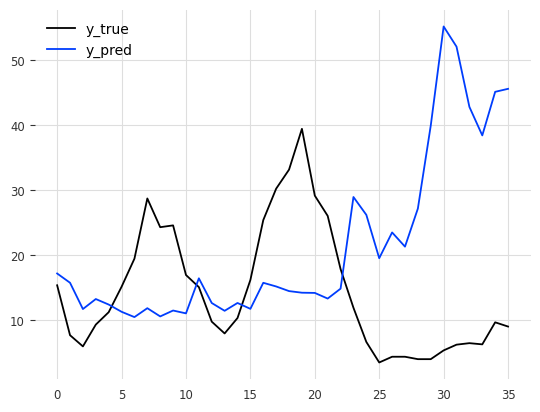

[W 2023-10-28 00:06:02,096] Trial 0 failed with parameters: {'random_state': 24, 'n_estimators': 199, 'max_depth': 13} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 432.7171
rmse: 20.80185259745839
mape: 2.126826378459543
⭐️⭐️ City:  BR Vũng Tàu


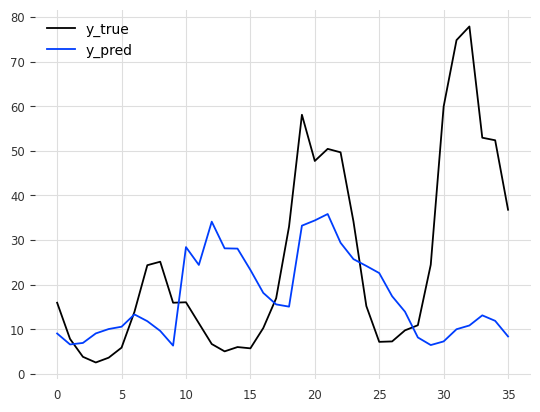

[W 2023-10-28 00:06:02,422] Trial 0 failed with parameters: {'random_state': 21, 'n_estimators': 198, 'max_depth': 10} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 589.2501
rmse: 24.27447514314134
mape: 1.0889545724173029
⭐️⭐️ City:  Bình Phước


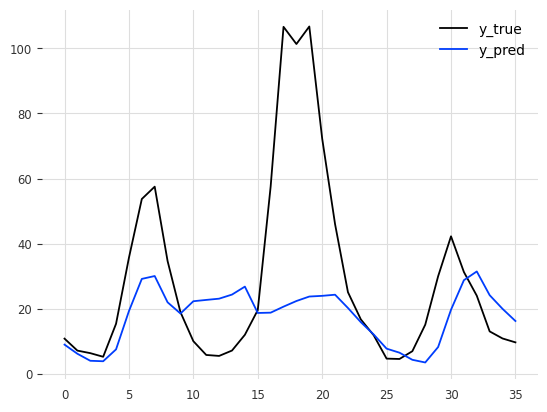

[W 2023-10-28 00:06:02,710] Trial 0 failed with parameters: {'random_state': 30, 'n_estimators': 162, 'max_depth': 15} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 817.0097
rmse: 28.58338161992737
mape: 0.6929389437675346
⭐️⭐️ City:  Bình Thuận


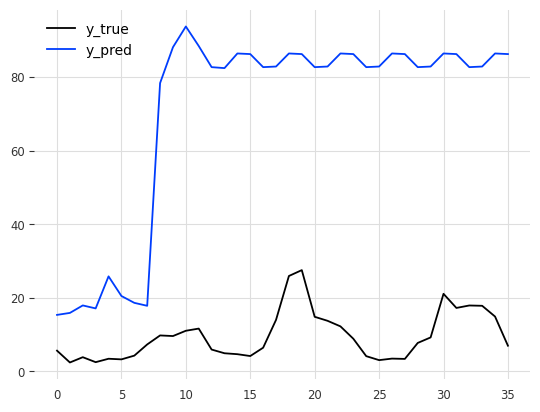

[W 2023-10-28 00:06:02,868] Trial 0 failed with parameters: {'random_state': 7, 'n_estimators': 54, 'max_depth': 4} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, 

mean_squared_error: 4308.6641
rmse: 65.64041550670703
mape: 8.714650915391715
⭐️⭐️ City:  Bình Định


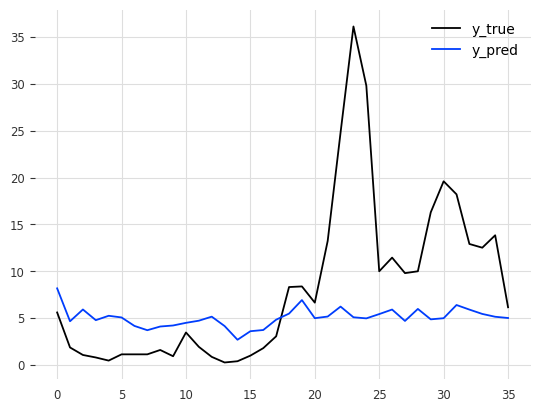

[W 2023-10-28 00:06:03,084] Trial 0 failed with parameters: {'random_state': 29, 'n_estimators': 104, 'max_depth': 11} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 81.8161
rmse: 9.045223843790714
mape: 2.117241305533783
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


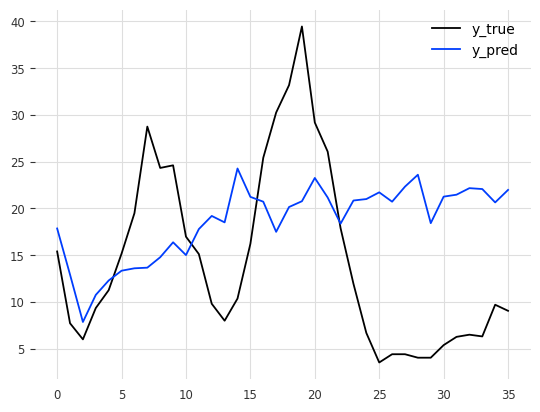

[W 2023-10-28 00:06:03,201] Trial 0 failed with parameters: {'random_state': 20} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 130.9435
rmse: 11.443053817062987
mape: 1.2836417352032632
⭐️⭐️ City:  BR Vũng Tàu


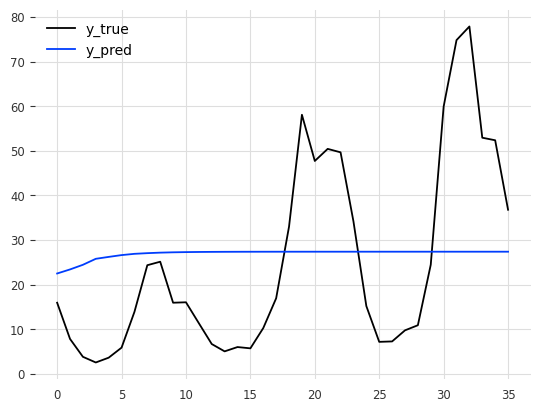

[W 2023-10-28 00:06:03,308] Trial 0 failed with parameters: {'random_state': 37} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 454.8957
rmse: 21.32828300178943
mape: 1.748619915243717
⭐️⭐️ City:  Bình Phước


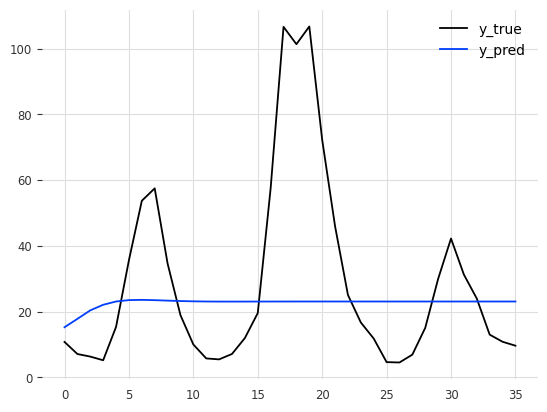

[W 2023-10-28 00:06:03,410] Trial 0 failed with parameters: {'random_state': 36} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 847.5365
rmse: 29.112480733777176
mape: 1.1493342981090755
⭐️⭐️ City:  Bình Thuận


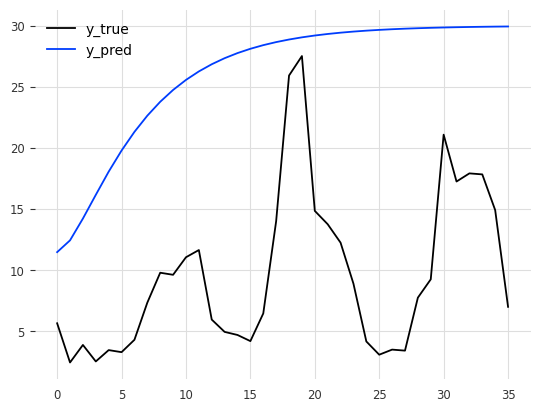

[W 2023-10-28 00:06:03,512] Trial 0 failed with parameters: {'random_state': 9} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate

mean_squared_error: 309.0992
rmse: 17.581217308384197
mape: 2.911761283208122
⭐️⭐️ City:  Bình Định


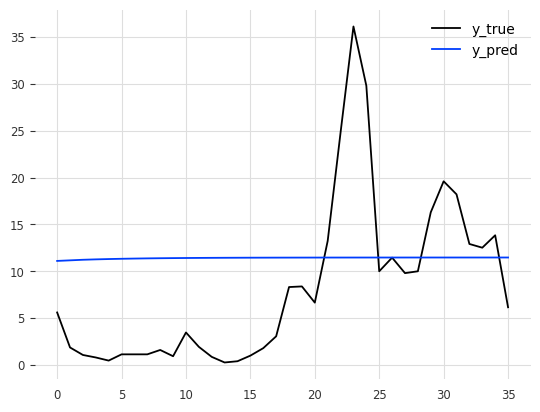

[W 2023-10-28 00:06:03,615] Trial 0 failed with parameters: {'random_state': 35} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 86.1294
rmse: 9.280592790595216
mape: 5.833355758446439
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LightGBMModel
⭐️⭐️ City:  An Giang
⭐️⭐️ City:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước
⭐️⭐️ City:  Bình Thuận
⭐️⭐️ City:  Bình Định
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


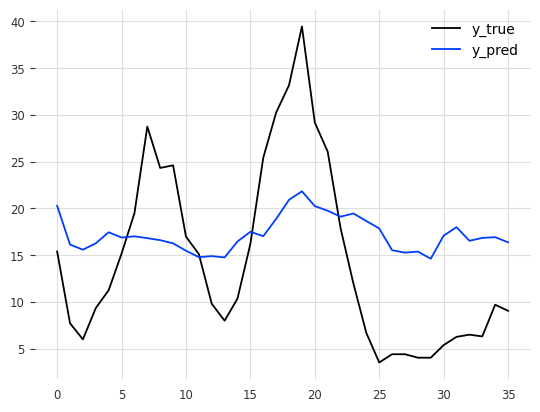

[W 2023-10-28 00:06:04,152] Trial 0 failed with parameters: {'learning_rate': 0.019674649033044014, 'n_estimators': 85, 'max_depth': 5, 'random_state': 557, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 10.747103160424414, 'border_count': 187, 'l2_leaf_reg': 6.68165569228553, 'random_strength': 5.00758226142199} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, loc

mean_squared_error: 81.3787
rmse: 9.021014455716937
mape: 0.9887711605311799
⭐️⭐️ City:  BR Vũng Tàu


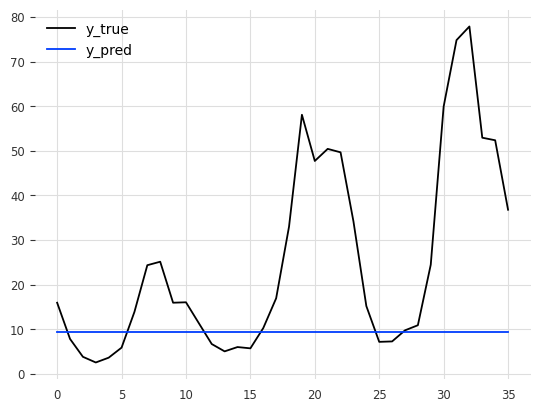

[W 2023-10-28 00:06:04,380] Trial 0 failed with parameters: {'learning_rate': 0.03205274733229075, 'n_estimators': 68, 'max_depth': 14, 'random_state': 615, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 19.965324333891832, 'border_count': 3, 'l2_leaf_reg': 1.2305555336278635, 'random_strength': 3.2930126976062275} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, l

mean_squared_error: 705.0470
rmse: 26.552721814156858
mape: 0.6691009843425054
⭐️⭐️ City:  Bình Phước


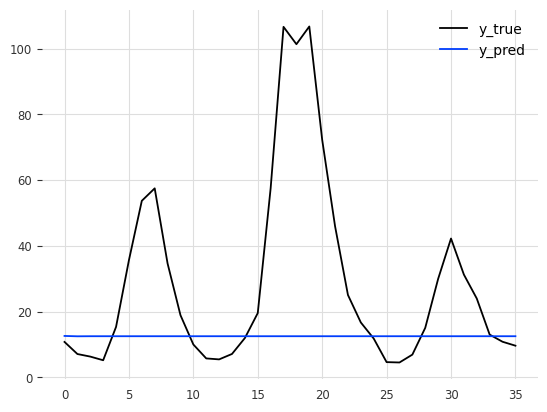

[W 2023-10-28 00:06:04,572] Trial 0 failed with parameters: {'learning_rate': 0.008429125408140954, 'n_estimators': 72, 'max_depth': 2, 'random_state': 718, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 21.27229083721943, 'border_count': 205, 'l2_leaf_reg': 5.485413275668183, 'random_strength': 9.061788948109932} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid

mean_squared_error: 1095.1777
rmse: 33.093468872531574
mape: 0.6542350488428083
⭐️⭐️ City:  Bình Thuận


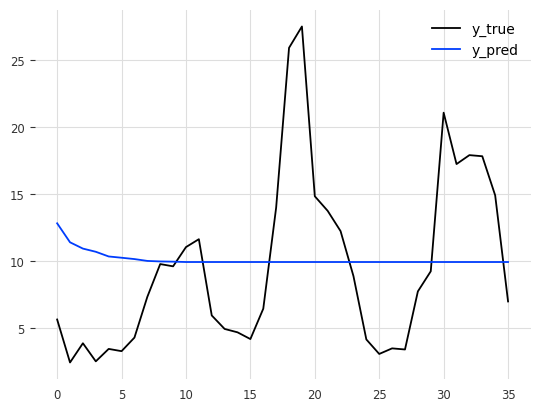

[W 2023-10-28 00:06:04,756] Trial 0 failed with parameters: {'learning_rate': 0.0021688251205982767, 'n_estimators': 133, 'max_depth': 3, 'random_state': 645, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 69.18411820101024, 'border_count': 164, 'l2_leaf_reg': 7.415558933173741, 'random_strength': 3.6047652432687483} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_va

mean_squared_error: 45.4898
rmse: 6.744609338228821
mape: 0.9332719261709068
⭐️⭐️ City:  Bình Định


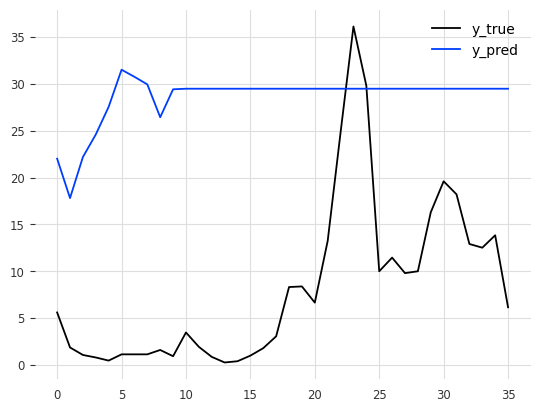

[W 2023-10-28 00:06:10,699] Trial 0 failed with parameters: {'learning_rate': 0.04948999330375501, 'n_estimators': 114, 'max_depth': 14, 'random_state': 180, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 84.19362594463296, 'border_count': 167, 'l2_leaf_reg': 9.31074114681853, 'random_strength': 7.574549867539062} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid

mean_squared_error: 487.2390
rmse: 22.073491001957194
mape: 15.567603603262594
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


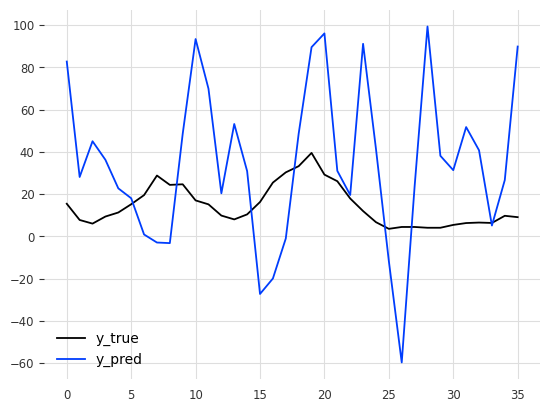

[W 2023-10-28 00:06:11,525] Trial 0 failed with parameters: {'random_state': 22, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 1853.5172
rmse: 43.052493218635895
mape: 3.9879544356455128
⭐️⭐️ City:  BR Vũng Tàu


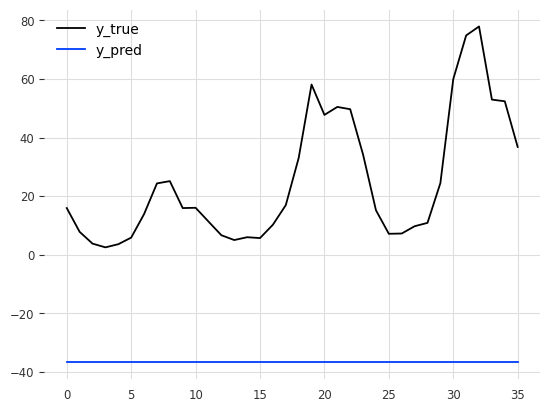

[W 2023-10-28 00:06:12,119] Trial 0 failed with parameters: {'random_state': 43, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 4272.2600
rmse: 65.36252786845698
mape: 4.396369894770805
⭐️⭐️ City:  Bình Phước


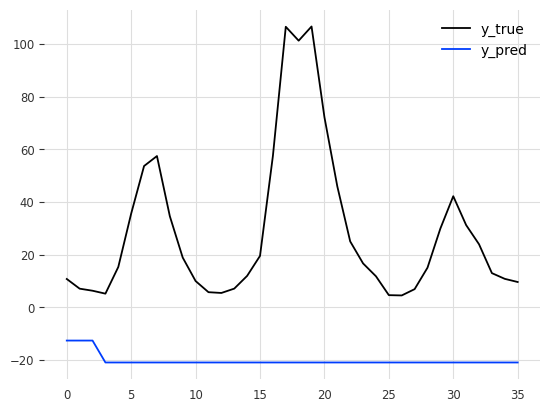

[W 2023-10-28 00:06:12,836] Trial 0 failed with parameters: {'random_state': 23, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 3276.3883
rmse: 57.23974376394424
mape: 2.5541813166664675
⭐️⭐️ City:  Bình Thuận


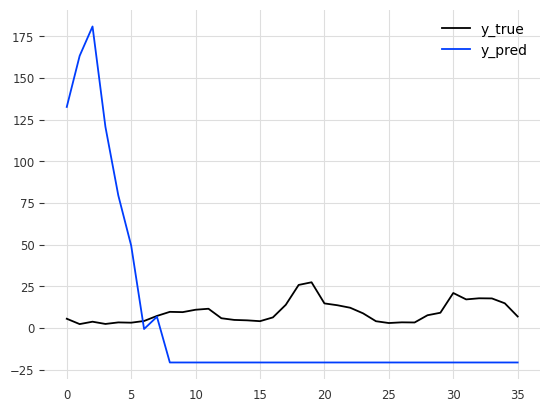

[W 2023-10-28 00:06:13,756] Trial 0 failed with parameters: {'random_state': 10, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 3465.1572
rmse: 58.865586129381896
mape: 8.907231955214488
⭐️⭐️ City:  Bình Định


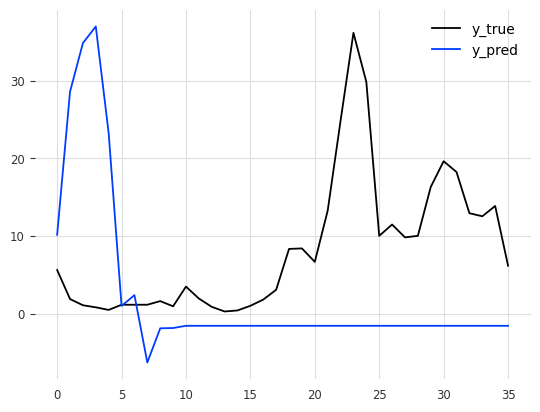

[W 2023-10-28 00:06:14,474] Trial 0 failed with parameters: {'random_state': 5, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse,

mean_squared_error: 274.7077
rmse: 16.57430758513483
mape: 5.494417388702805
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  2
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


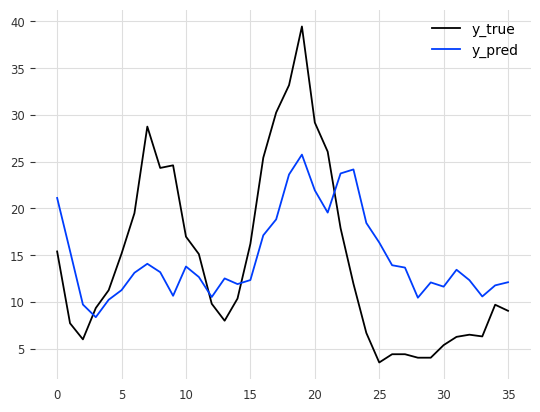

[W 2023-10-28 00:06:14,742] Trial 0 failed with parameters: {'random_state': 37, 'n_estimators': 110, 'max_depth': 10} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 62.5747
rmse: 7.91042000474778
mape: 0.7371785725332904
⭐️⭐️ City:  BR Vũng Tàu


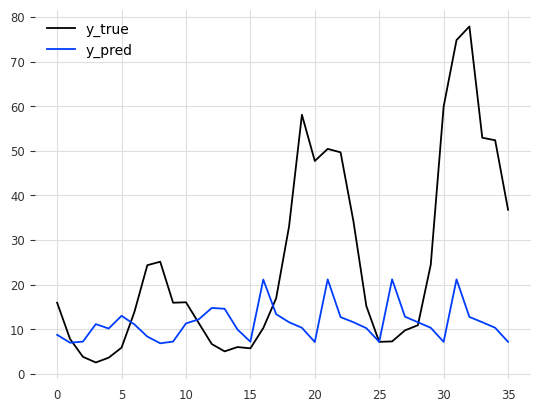

[W 2023-10-28 00:06:15,270] Trial 0 failed with parameters: {'random_state': 32, 'n_estimators': 99, 'max_depth': 7} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse,

mean_squared_error: 640.0135
rmse: 25.298488622630963
mape: 0.7774358664118661
⭐️⭐️ City:  Bình Phước


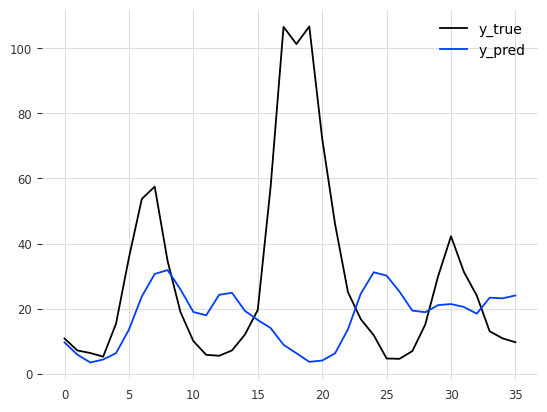

[W 2023-10-28 00:06:15,466] Trial 0 failed with parameters: {'random_state': 33, 'n_estimators': 92, 'max_depth': 9} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse,

mean_squared_error: 1208.2331
rmse: 34.75964689685256
mape: 1.055300641379535
⭐️⭐️ City:  Bình Thuận


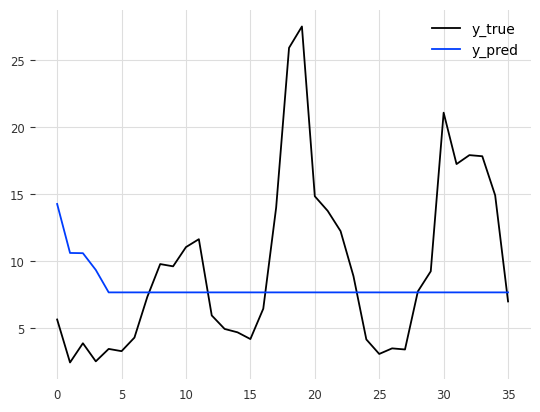

[W 2023-10-28 00:06:15,729] Trial 0 failed with parameters: {'random_state': 26, 'n_estimators': 172, 'max_depth': 2} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse

mean_squared_error: 50.8918
rmse: 7.133851877289217
mape: 0.7611894699911328
⭐️⭐️ City:  Bình Định


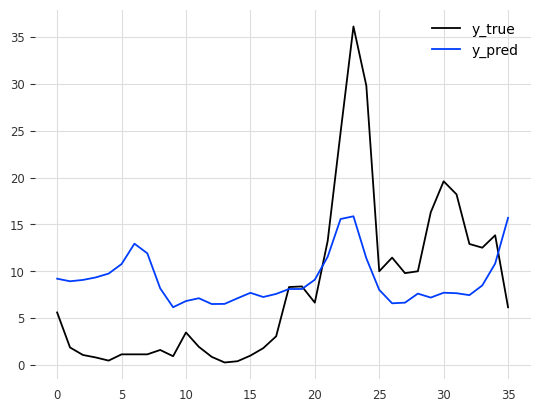

[W 2023-10-28 00:06:15,932] Trial 0 failed with parameters: {'random_state': 13, 'n_estimators': 90, 'max_depth': 13} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse

mean_squared_error: 64.6055
rmse: 8.03775692257249
mape: 4.163389710743664
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


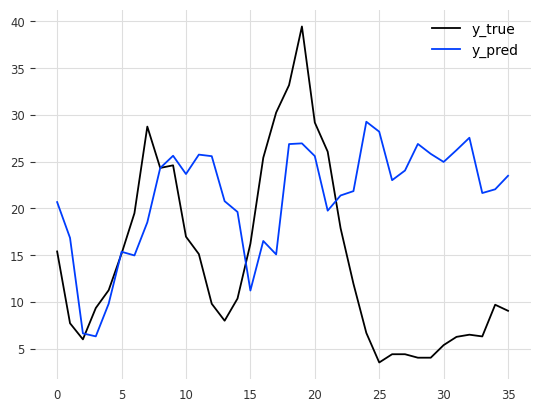

[W 2023-10-28 00:06:16,039] Trial 0 failed with parameters: {'random_state': 28} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 174.2329
rmse: 13.199731086599058
mape: 1.567751539048323
⭐️⭐️ City:  BR Vũng Tàu


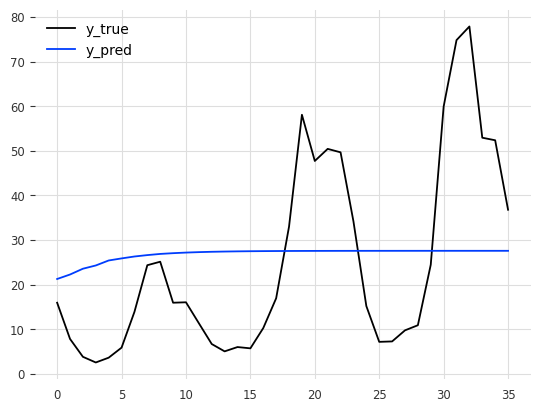

[W 2023-10-28 00:06:16,198] Trial 0 failed with parameters: {'random_state': 2} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate

mean_squared_error: 446.4874
rmse: 21.13024841090257
mape: 1.7113164569531716
⭐️⭐️ City:  Bình Phước


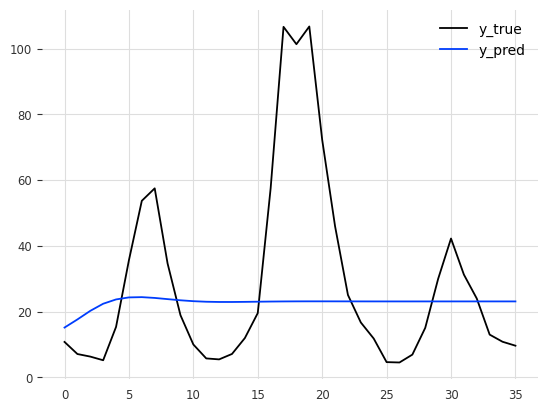

[W 2023-10-28 00:06:16,303] Trial 0 failed with parameters: {'random_state': 40} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 843.5441
rmse: 29.04382995069874
mape: 1.148082963268442
⭐️⭐️ City:  Bình Thuận


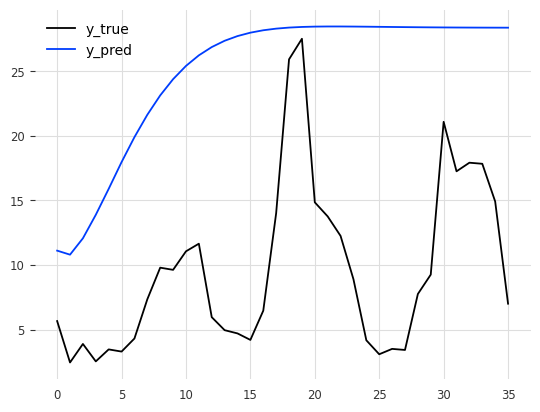

[W 2023-10-28 00:06:16,404] Trial 0 failed with parameters: {'random_state': 36} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 278.0318
rmse: 16.674285006544668
mape: 2.7226790688240086
⭐️⭐️ City:  Bình Định


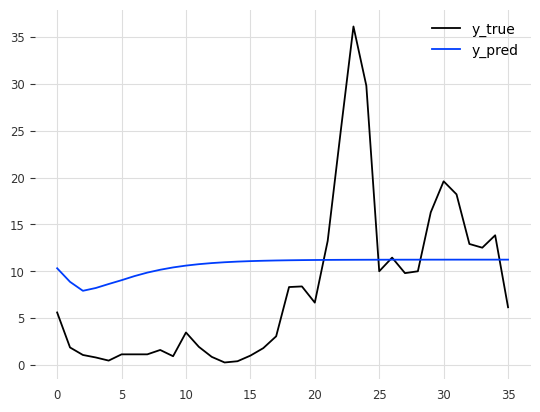

[W 2023-10-28 00:06:16,508] Trial 0 failed with parameters: {'random_state': 19} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 75.0439
rmse: 8.662789607556691
mape: 5.122737026503078
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LightGBMModel
⭐️⭐️ City:  An Giang
⭐️⭐️ City:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước
⭐️⭐️ City:  Bình Thuận
⭐️⭐️ City:  Bình Định
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


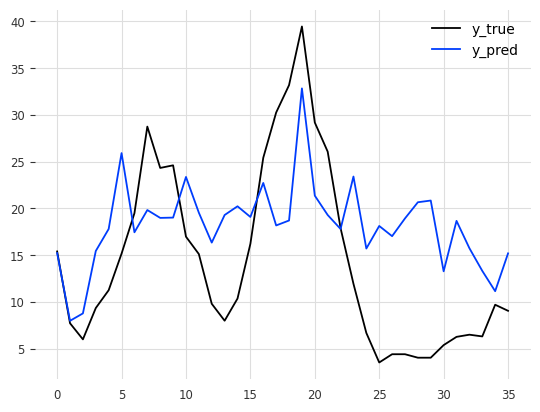

[W 2023-10-28 00:06:21,530] Trial 0 failed with parameters: {'learning_rate': 0.08114280704698157, 'n_estimators': 113, 'max_depth': 11, 'random_state': 321, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 70.75741731361698, 'border_count': 167, 'l2_leaf_reg': 2.4372049243529923, 'random_strength': 9.135220143457968} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, 

mean_squared_error: 81.7759
rmse: 9.043005471327437
mape: 1.014293377973708
⭐️⭐️ City:  BR Vũng Tàu


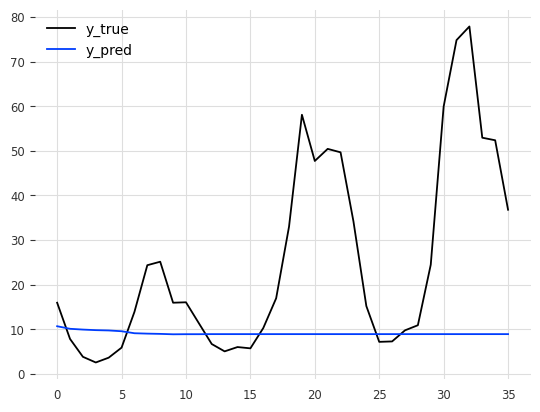

[W 2023-10-28 00:06:21,692] Trial 0 failed with parameters: {'learning_rate': 0.006077409563670277, 'n_estimators': 113, 'max_depth': 2, 'random_state': 617, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 17.505077794038492, 'border_count': 97, 'l2_leaf_reg': 9.398420045549114, 'random_strength': 1.8347965543174016} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_val

mean_squared_error: 723.3986
rmse: 26.896070377032256
mape: 0.67949216084869
⭐️⭐️ City:  Bình Phước


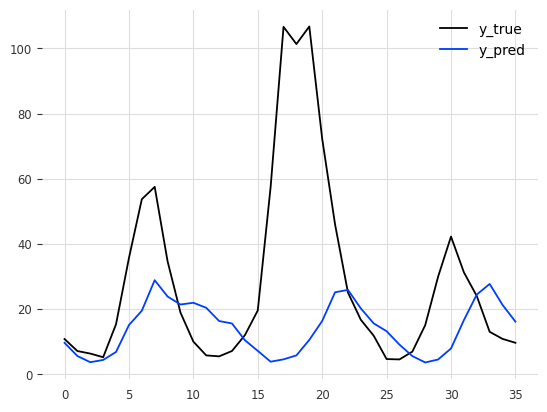

[W 2023-10-28 00:06:35,170] Trial 0 failed with parameters: {'learning_rate': 0.04512719113598676, 'n_estimators': 76, 'max_depth': 14, 'random_state': 47, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 41.39573326094132, 'border_count': 155, 'l2_leaf_reg': 0.5528082455476563, 'random_strength': 3.3456883596856373} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, l

mean_squared_error: 1144.7683
rmse: 33.834424882967745
mape: 0.70643741292328
⭐️⭐️ City:  Bình Thuận


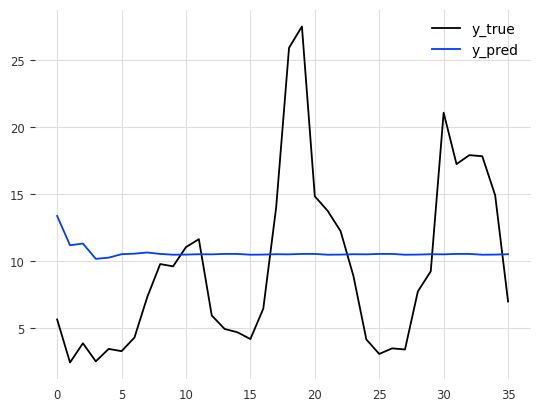

[W 2023-10-28 00:06:35,361] Trial 0 failed with parameters: {'learning_rate': 0.03413072359206814, 'n_estimators': 140, 'max_depth': 3, 'random_state': 944, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 32.118622144037566, 'border_count': 142, 'l2_leaf_reg': 8.96219794798953, 'random_strength': 4.955315365884098} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid

mean_squared_error: 44.9818
rmse: 6.706848923846521
mape: 0.968728593021275
⭐️⭐️ City:  Bình Định


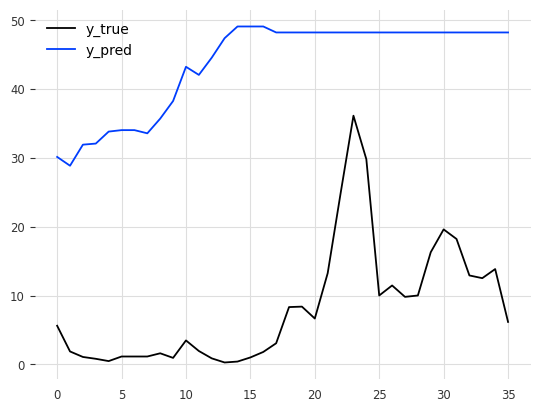

[W 2023-10-28 00:06:35,586] Trial 0 failed with parameters: {'learning_rate': 0.047314772669327286, 'n_estimators': 183, 'max_depth': 3, 'random_state': 95, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 9.100854513911102, 'border_count': 155, 'l2_leaf_reg': 4.5565041786637845, 'random_strength': 4.7519274317848605} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_val

mean_squared_error: 1322.0954
rmse: 36.360629622819076
mape: 23.116888827313737
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


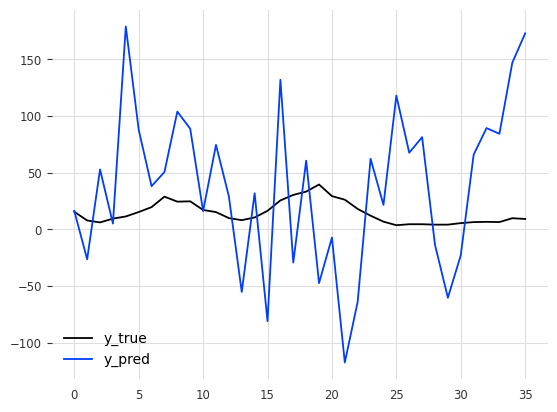

[W 2023-10-28 00:06:36,427] Trial 0 failed with parameters: {'random_state': 13, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 5858.1181
rmse: 76.53834391022303
mape: 6.817496015129198
⭐️⭐️ City:  BR Vũng Tàu


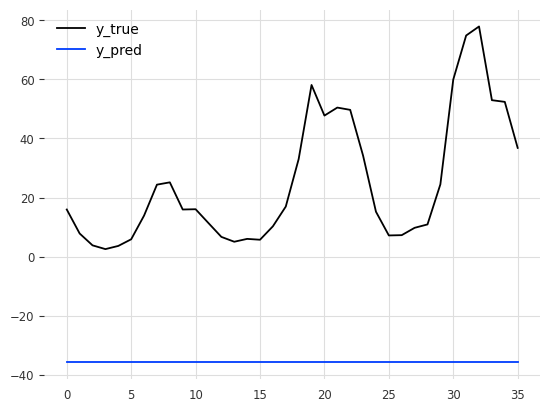

[W 2023-10-28 00:06:37,152] Trial 0 failed with parameters: {'random_state': 0, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse,

mean_squared_error: 4161.8602
rmse: 64.51248111560257
mape: 4.313030673124381
⭐️⭐️ City:  Bình Phước


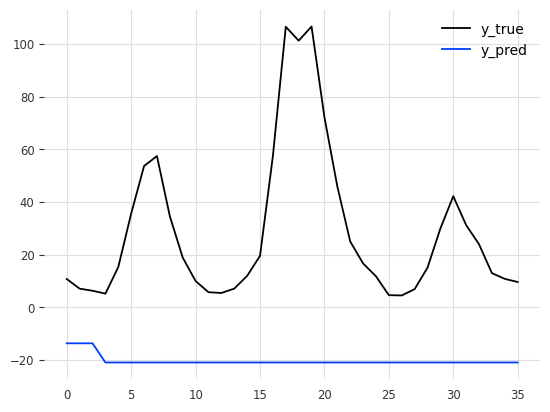

[W 2023-10-28 00:06:37,900] Trial 0 failed with parameters: {'random_state': 35, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 3279.5377
rmse: 57.267247626097785
mape: 2.5650727252604764
⭐️⭐️ City:  Bình Thuận


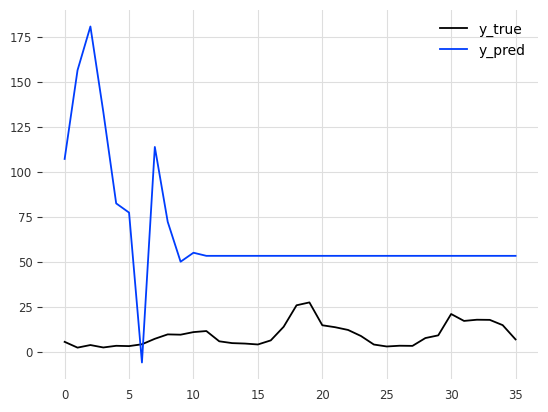

[W 2023-10-28 00:06:38,650] Trial 0 failed with parameters: {'random_state': 13, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 4398.0182
rmse: 66.31755546497766
mape: 11.339807282807378
⭐️⭐️ City:  Bình Định


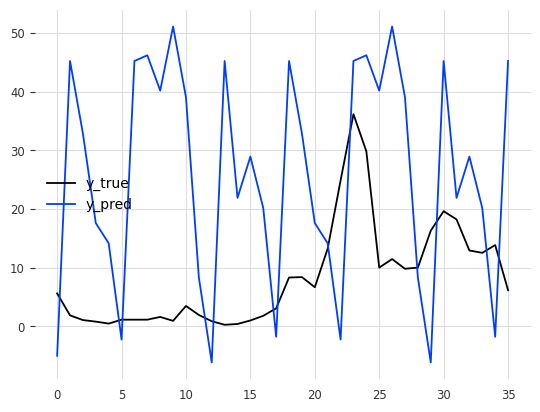

[W 2023-10-28 00:06:39,405] Trial 0 failed with parameters: {'random_state': 36, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 727.3241
rmse: 26.96894750710439
mape: 16.142333048514903
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  3
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


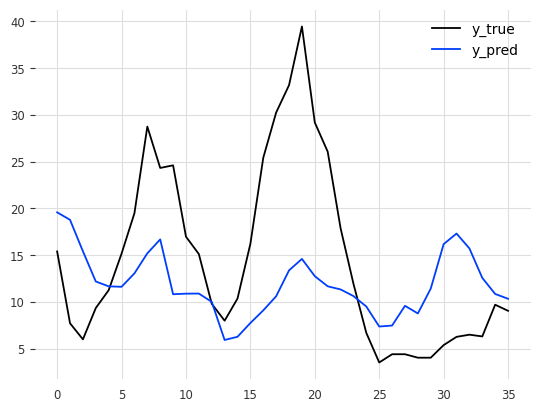

[W 2023-10-28 00:06:39,695] Trial 0 failed with parameters: {'random_state': 37, 'n_estimators': 94, 'max_depth': 8} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse,

mean_squared_error: 98.8406
rmse: 9.94186089012229
mape: 0.674638883657362
⭐️⭐️ City:  BR Vũng Tàu


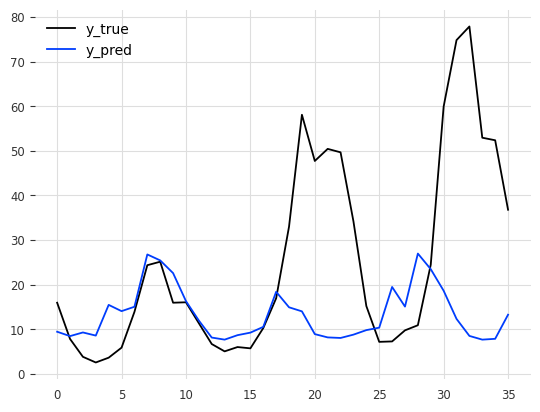

[W 2023-10-28 00:06:39,941] Trial 0 failed with parameters: {'random_state': 34, 'n_estimators': 89, 'max_depth': 6} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse,

mean_squared_error: 661.8254
rmse: 25.72596724729476
mape: 0.7053075667103933
⭐️⭐️ City:  Bình Phước


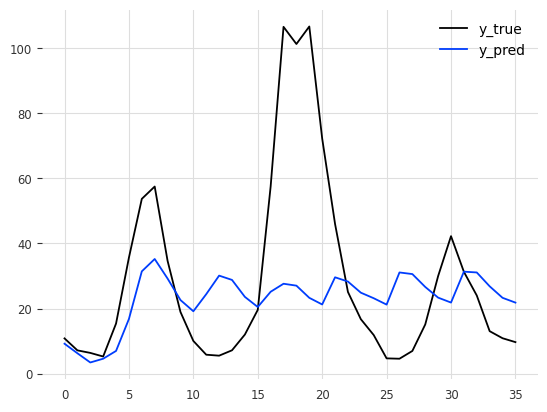

[W 2023-10-28 00:06:40,191] Trial 0 failed with parameters: {'random_state': 20, 'n_estimators': 115, 'max_depth': 13} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 795.4894
rmse: 28.204421609109215
mape: 1.0879095060279964
⭐️⭐️ City:  Bình Thuận


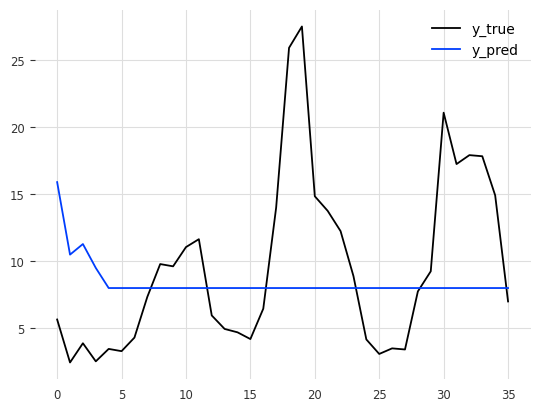

[W 2023-10-28 00:06:40,378] Trial 0 failed with parameters: {'random_state': 19, 'n_estimators': 81, 'max_depth': 2} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse,

mean_squared_error: 50.5661
rmse: 7.110987873561397
mape: 0.7926861927175362
⭐️⭐️ City:  Bình Định


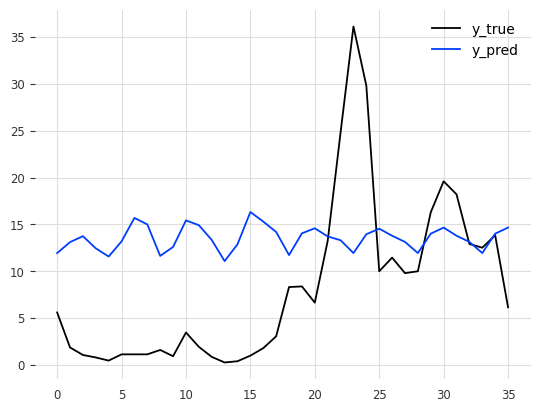

[W 2023-10-28 00:06:40,679] Trial 0 failed with parameters: {'random_state': 19, 'n_estimators': 156, 'max_depth': 12} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 108.2198
rmse: 10.402875798723393
mape: 6.724766349043451
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


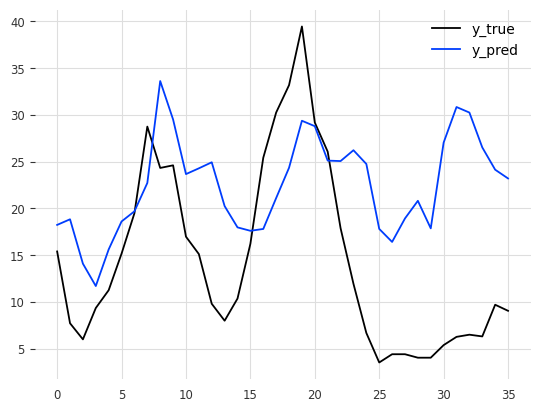

[W 2023-10-28 00:06:40,791] Trial 0 failed with parameters: {'random_state': 27} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 148.3613
rmse: 12.18036631035629
mape: 1.4026674749901378
⭐️⭐️ City:  BR Vũng Tàu


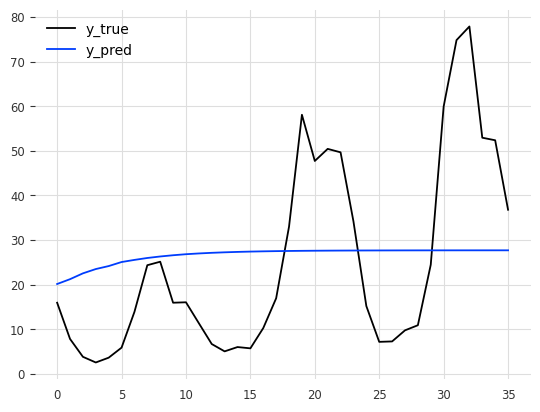

[W 2023-10-28 00:06:40,908] Trial 0 failed with parameters: {'random_state': 2} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate

mean_squared_error: 437.8742
rmse: 20.925443630672245
mape: 1.6687337346492803
⭐️⭐️ City:  Bình Phước


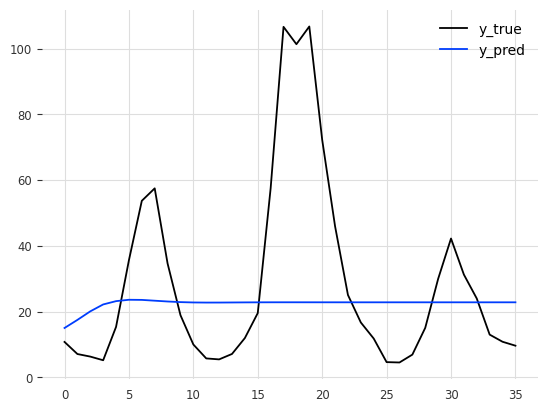

[W 2023-10-28 00:06:41,020] Trial 0 failed with parameters: {'random_state': 19} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 849.9052
rmse: 29.15313426849925
mape: 1.13514327075415
⭐️⭐️ City:  Bình Thuận


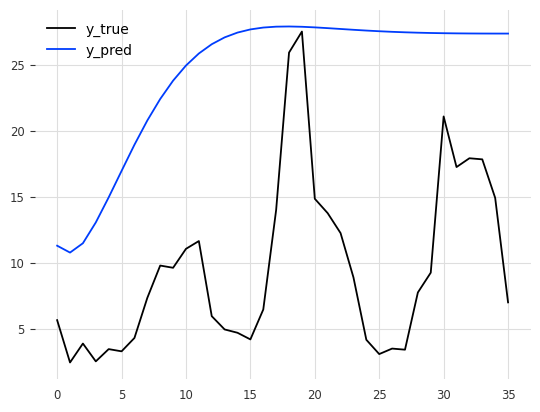

[W 2023-10-28 00:06:41,134] Trial 0 failed with parameters: {'random_state': 24} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 256.8116
rmse: 16.02534298330391
mape: 2.6141926489243237
⭐️⭐️ City:  Bình Định


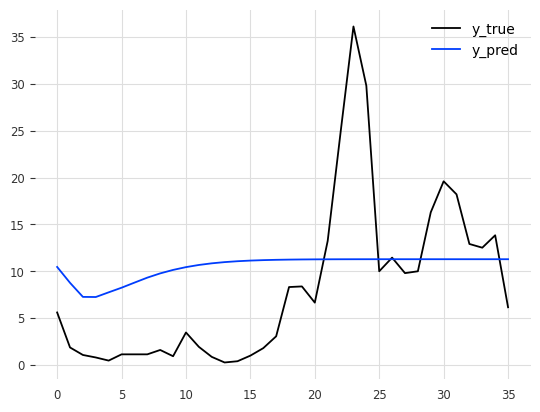

[W 2023-10-28 00:06:41,271] Trial 0 failed with parameters: {'random_state': 5} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate

mean_squared_error: 72.6489
rmse: 8.523431827063904
mape: 4.958833326446553
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LightGBMModel
⭐️⭐️ City:  An Giang
⭐️⭐️ City:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước
⭐️⭐️ City:  Bình Thuận
⭐️⭐️ City:  Bình Định
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


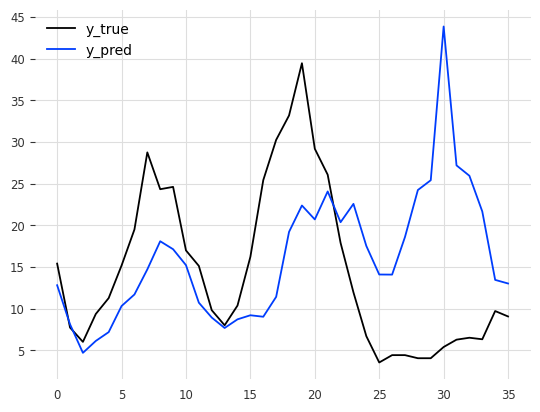

[W 2023-10-28 00:06:46,294] Trial 0 failed with parameters: {'learning_rate': 0.08994220288926455, 'n_estimators': 127, 'max_depth': 11, 'random_state': 389, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 68.28557526901355, 'border_count': 164, 'l2_leaf_reg': 8.218089386755988, 'random_strength': 9.90733929896747} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, lo

mean_squared_error: 159.6360
rmse: 12.634714382493833
mape: 1.2386525688009458
⭐️⭐️ City:  BR Vũng Tàu


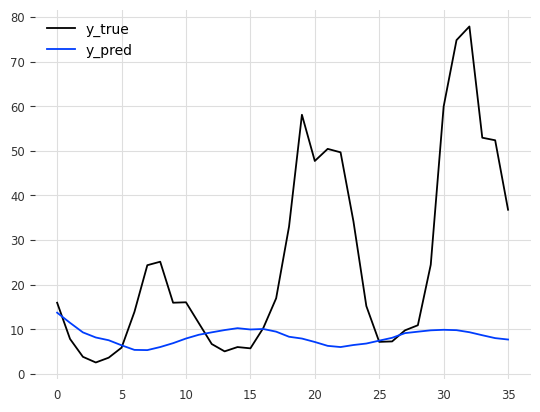

[W 2023-10-28 00:06:46,462] Trial 0 failed with parameters: {'learning_rate': 0.028721132728594483, 'n_estimators': 101, 'max_depth': 3, 'random_state': 802, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 17.33440274594011, 'border_count': 94, 'l2_leaf_reg': 8.484332703295781, 'random_strength': 6.0813005758035255} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_vali

mean_squared_error: 751.9663
rmse: 27.42200380292469
mape: 0.6586227309225499
⭐️⭐️ City:  Bình Phước


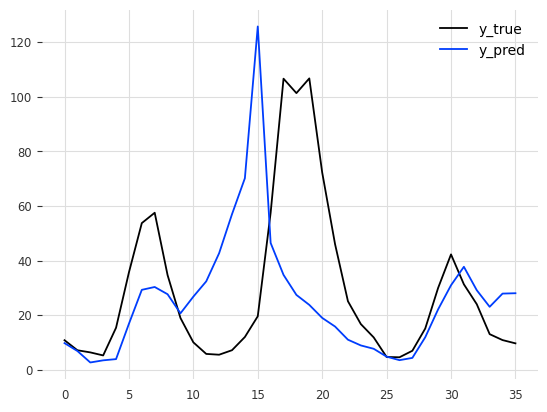

[W 2023-10-28 00:06:57,562] Trial 0 failed with parameters: {'learning_rate': 0.037085590415199286, 'n_estimators': 135, 'max_depth': 14, 'random_state': 391, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 9.61222446890292, 'border_count': 157, 'l2_leaf_reg': 1.0229261039110402, 'random_strength': 0.3013498338581678} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_va

mean_squared_error: 1224.0036
rmse: 34.985763523947334
mape: 1.249606790972021
⭐️⭐️ City:  Bình Thuận


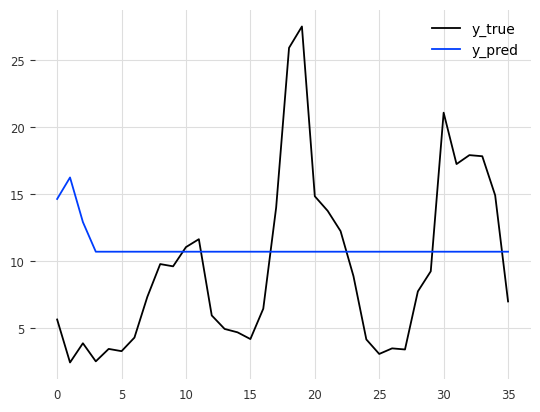

[W 2023-10-28 00:06:57,936] Trial 0 failed with parameters: {'learning_rate': 0.07627026485284444, 'n_estimators': 146, 'max_depth': 6, 'random_state': 292, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 35.82523449115492, 'border_count': 5, 'l2_leaf_reg': 6.344980623313128, 'random_strength': 6.236771692912845} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, loca

mean_squared_error: 49.8697
rmse: 7.0618464352027015
mape: 1.0664175491335206
⭐️⭐️ City:  Bình Định


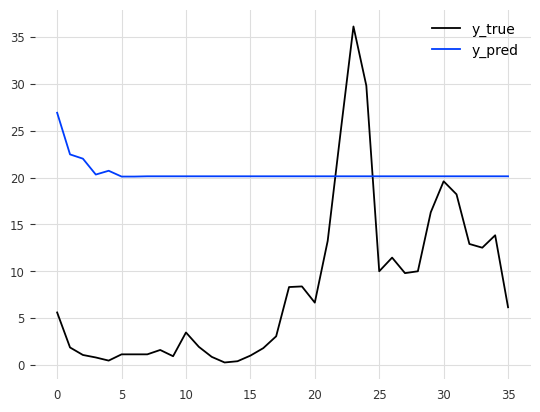

[W 2023-10-28 00:06:58,182] Trial 0 failed with parameters: {'learning_rate': 0.04188624608171524, 'n_estimators': 83, 'max_depth': 2, 'random_state': 707, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 62.119828921902084, 'border_count': 254, 'l2_leaf_reg': 7.236984548724449, 'random_strength': 9.331652549201912} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, lo

mean_squared_error: 230.5394
rmse: 15.183524340889932
mape: 10.960508247541354
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


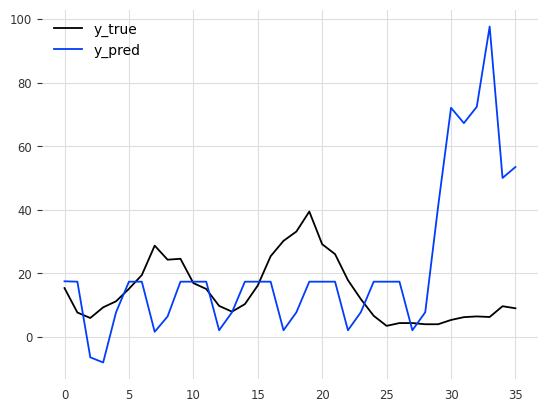

[W 2023-10-28 00:06:58,976] Trial 0 failed with parameters: {'random_state': 7, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse,

mean_squared_error: 849.3837
rmse: 29.144188199576877
mape: 2.471457800698286
⭐️⭐️ City:  BR Vũng Tàu


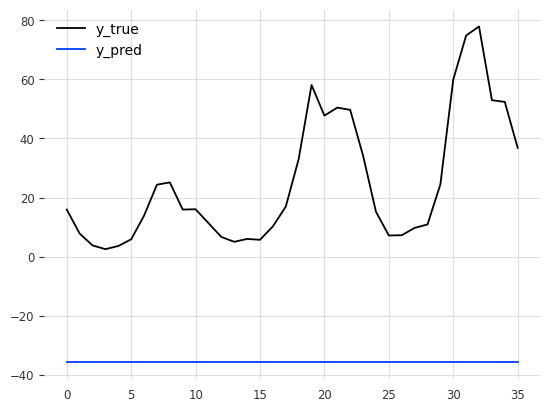

[W 2023-10-28 00:06:59,708] Trial 0 failed with parameters: {'random_state': 4, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse,

mean_squared_error: 4158.0886
rmse: 64.4832430709089
mape: 4.310161732664679
⭐️⭐️ City:  Bình Phước


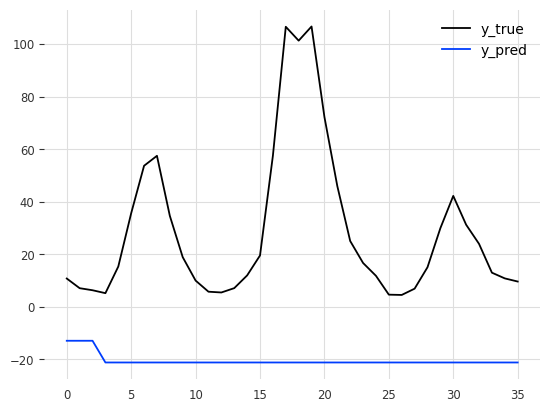

[W 2023-10-28 00:07:00,531] Trial 0 failed with parameters: {'random_state': 10, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 3299.6119
rmse: 57.442248661334524
mape: 2.5732276588010032
⭐️⭐️ City:  Bình Thuận


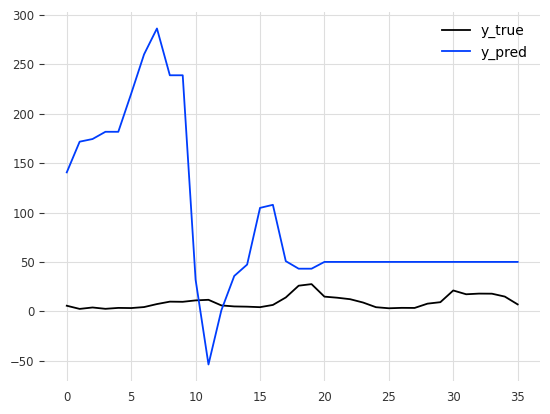

[W 2023-10-28 00:07:01,239] Trial 0 failed with parameters: {'random_state': 36, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 13601.7463
rmse: 116.62652506357789
mape: 17.43678151024322
⭐️⭐️ City:  Bình Định


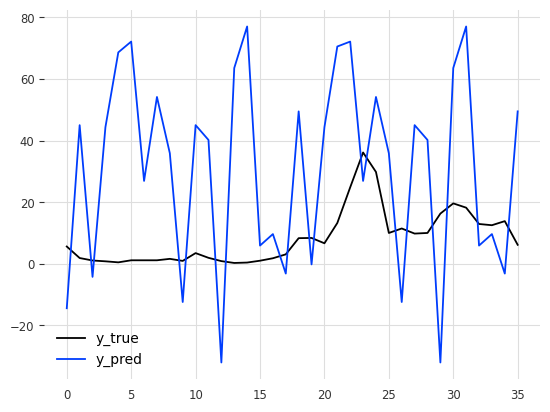

[W 2023-10-28 00:07:01,967] Trial 0 failed with parameters: {'random_state': 23, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 1547.9726
rmse: 39.344282424495574
mape: 26.614509546862074
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  4
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


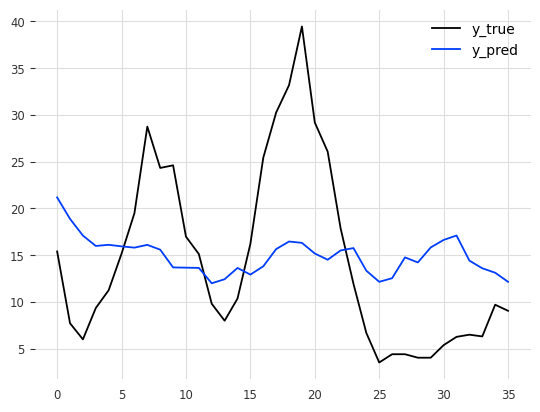

[W 2023-10-28 00:07:02,205] Trial 0 failed with parameters: {'random_state': 5, 'n_estimators': 99, 'max_depth': 4} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, 

mean_squared_error: 89.1057
rmse: 9.439580340950391
mape: 0.8679257293513369
⭐️⭐️ City:  BR Vũng Tàu


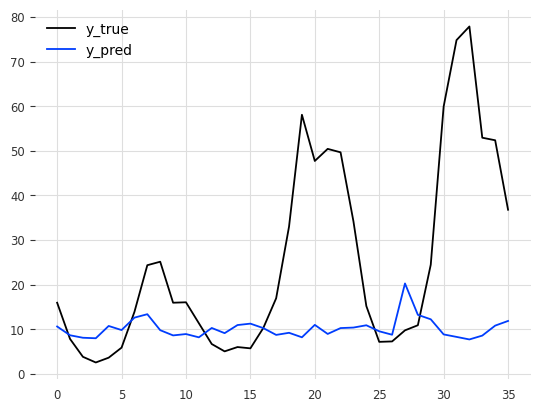

[W 2023-10-28 00:07:02,593] Trial 0 failed with parameters: {'random_state': 31, 'n_estimators': 185, 'max_depth': 6} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse

mean_squared_error: 710.7306
rmse: 26.65953070786368
mape: 0.6813098854762049
⭐️⭐️ City:  Bình Phước


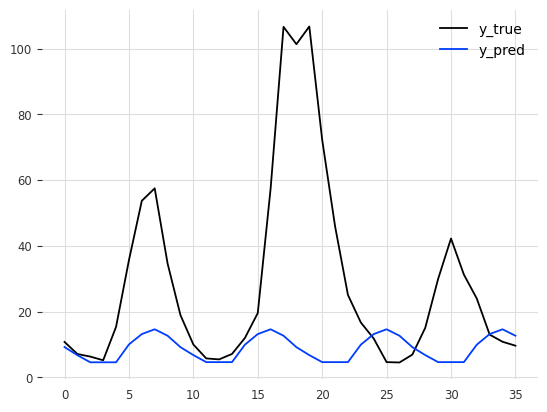

[W 2023-10-28 00:07:02,866] Trial 0 failed with parameters: {'random_state': 39, 'n_estimators': 162, 'max_depth': 4} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse

mean_squared_error: 1221.9312
rmse: 34.95613293895951
mape: 0.5954990422816776
⭐️⭐️ City:  Bình Thuận


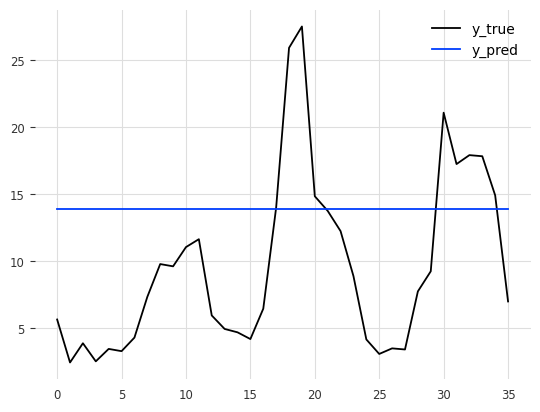

[W 2023-10-28 00:07:03,134] Trial 0 failed with parameters: {'random_state': 28, 'n_estimators': 178, 'max_depth': 1} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse

mean_squared_error: 61.0136
rmse: 7.811123321457241
mape: 1.3691799056151583
⭐️⭐️ City:  Bình Định


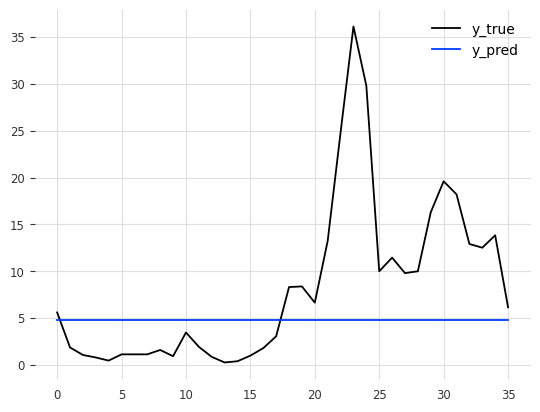

[W 2023-10-28 00:07:03,405] Trial 0 failed with parameters: {'random_state': 1, 'n_estimators': 178, 'max_depth': 1} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse,

mean_squared_error: 88.3373
rmse: 9.398793447536262
mape: 2.4213551742960506
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


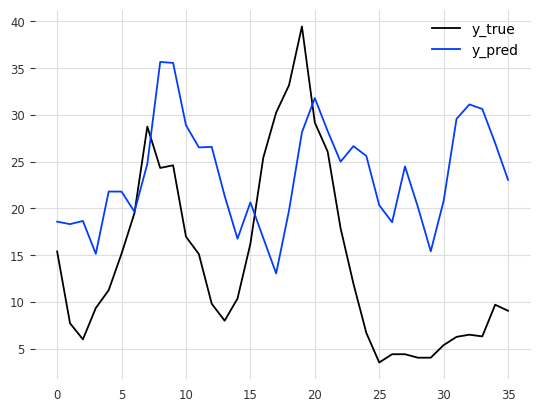

[W 2023-10-28 00:07:03,516] Trial 0 failed with parameters: {'random_state': 8} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate

mean_squared_error: 183.1562
rmse: 13.533520365118523
mape: 1.5437363976630414
⭐️⭐️ City:  BR Vũng Tàu


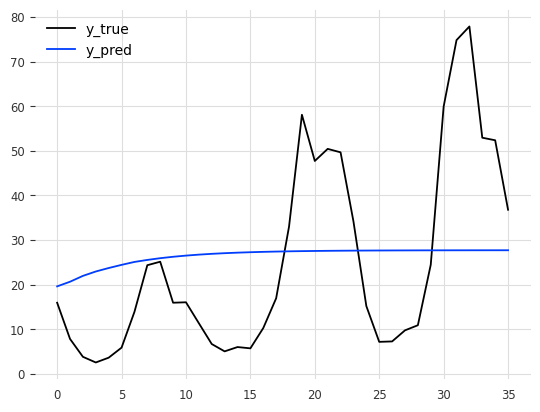

[W 2023-10-28 00:07:03,634] Trial 0 failed with parameters: {'random_state': 27} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 433.1386
rmse: 20.811983134925185
mape: 1.6417738846200949
⭐️⭐️ City:  Bình Phước


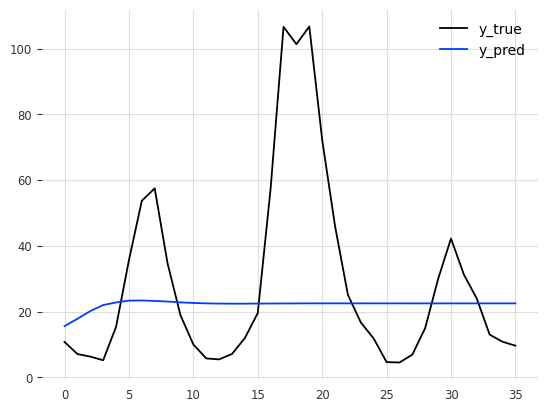

[W 2023-10-28 00:07:03,744] Trial 0 failed with parameters: {'random_state': 10} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 854.7337
rmse: 29.23582932882906
mape: 1.123549228874002
⭐️⭐️ City:  Bình Thuận


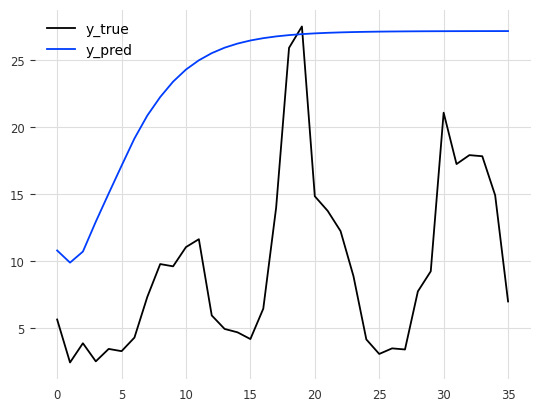

[W 2023-10-28 00:07:03,848] Trial 0 failed with parameters: {'random_state': 14} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 241.4652
rmse: 15.539149948537998
mape: 2.5372365070678806
⭐️⭐️ City:  Bình Định


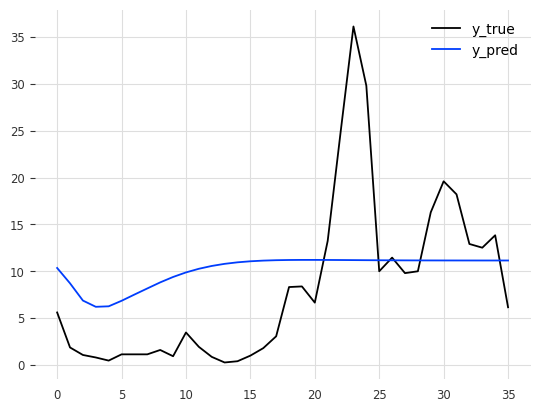

[W 2023-10-28 00:07:03,957] Trial 0 failed with parameters: {'random_state': 36} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 68.9017
rmse: 8.300707420718064
mape: 4.63962456301415
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LightGBMModel
⭐️⭐️ City:  An Giang
⭐️⭐️ City:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước
⭐️⭐️ City:  Bình Thuận
⭐️⭐️ City:  Bình Định
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


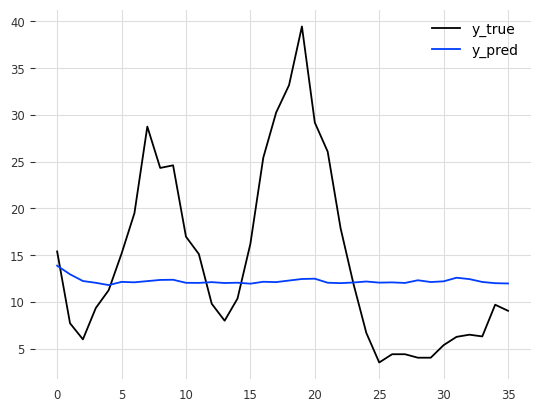

[W 2023-10-28 00:07:04,226] Trial 0 failed with parameters: {'learning_rate': 0.0034401118184341608, 'n_estimators': 53, 'max_depth': 4, 'random_state': 101, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 83.27135215127417, 'border_count': 136, 'l2_leaf_reg': 0.6878767630898807, 'random_strength': 2.815627979773683} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_val

mean_squared_error: 96.8957
rmse: 9.84356110743233
mape: 0.7021789853221864
⭐️⭐️ City:  BR Vũng Tàu


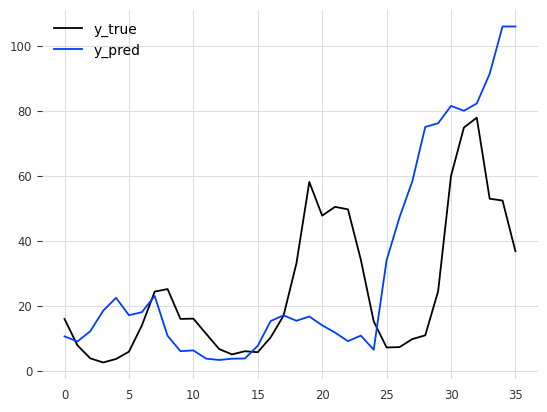

[W 2023-10-28 00:07:08,342] Trial 0 failed with parameters: {'learning_rate': 0.06734853979694032, 'n_estimators': 107, 'max_depth': 11, 'random_state': 0, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 49.5593480524318, 'border_count': 191, 'l2_leaf_reg': 0.1381601533098472, 'random_strength': 5.803970033339128} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, loc

mean_squared_error: 816.1566
rmse: 28.5684554931441
mape: 1.4443020186023972
⭐️⭐️ City:  Bình Phước


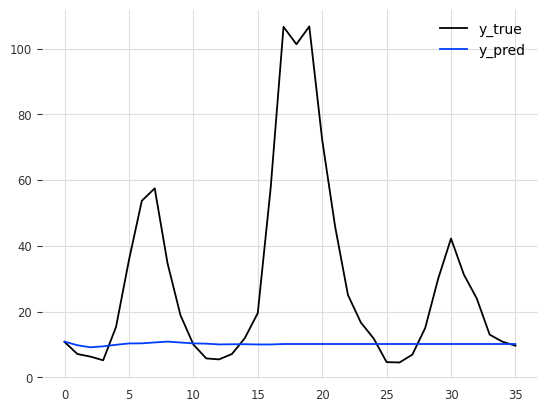

[W 2023-10-28 00:07:08,906] Trial 0 failed with parameters: {'learning_rate': 0.008000641748227063, 'n_estimators': 114, 'max_depth': 8, 'random_state': 346, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 79.82192581251695, 'border_count': 169, 'l2_leaf_reg': 9.624406787259671, 'random_strength': 4.123020316652387} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_vali

mean_squared_error: 1175.2715
rmse: 34.2822333696924
mape: 0.5732498019967074
⭐️⭐️ City:  Bình Thuận


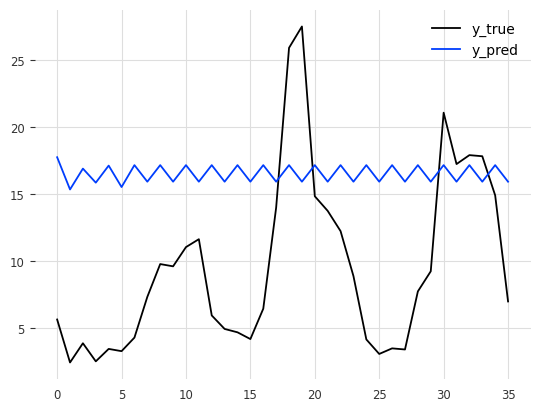

[W 2023-10-28 00:07:09,169] Trial 0 failed with parameters: {'learning_rate': 0.03067312056953751, 'n_estimators': 118, 'max_depth': 3, 'random_state': 767, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 22.422815701193265, 'border_count': 16, 'l2_leaf_reg': 7.321146152332813, 'random_strength': 7.68341582544043} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, loc

mean_squared_error: 90.5643
rmse: 9.516525733401014
mape: 1.734944529668474
⭐️⭐️ City:  Bình Định


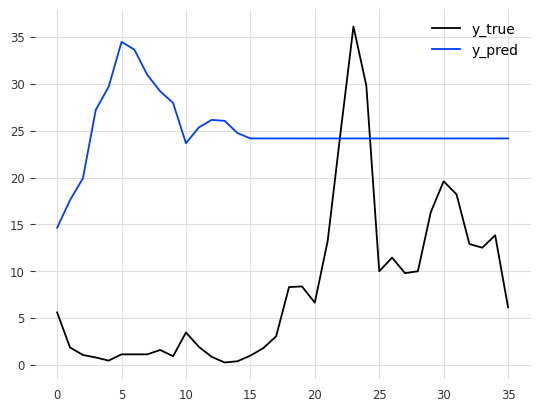

[W 2023-10-28 00:07:11,042] Trial 0 failed with parameters: {'learning_rate': 0.07935070523467538, 'n_estimators': 186, 'max_depth': 11, 'random_state': 997, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 94.38311591913745, 'border_count': 97, 'l2_leaf_reg': 0.6992195447729841, 'random_strength': 9.315440210025223} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_vali

mean_squared_error: 384.0051
rmse: 19.59604796608314
mape: 14.477909175436874
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


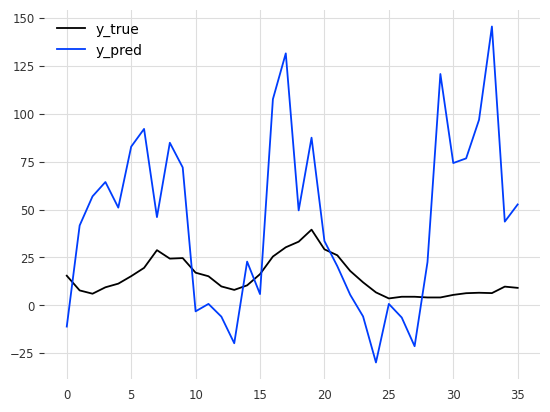

[W 2023-10-28 00:07:11,857] Trial 0 failed with parameters: {'random_state': 24, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 2877.8154
rmse: 53.645273807506214
mape: 4.819872300591578
⭐️⭐️ City:  BR Vũng Tàu


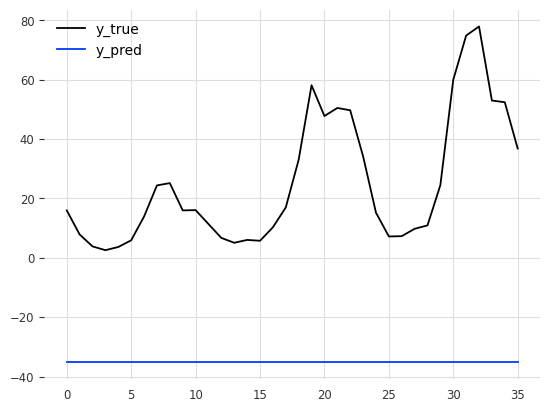

[W 2023-10-28 00:07:12,575] Trial 0 failed with parameters: {'random_state': 39, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 4095.2732
rmse: 63.99432130998024
mape: 4.262162570545416
⭐️⭐️ City:  Bình Phước


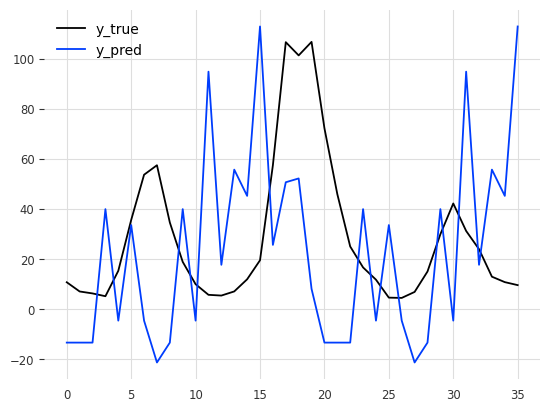

[W 2023-10-28 00:07:13,403] Trial 0 failed with parameters: {'random_state': 16, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 2435.8502
rmse: 49.35433334373919
mape: 2.742239861739969
⭐️⭐️ City:  Bình Thuận


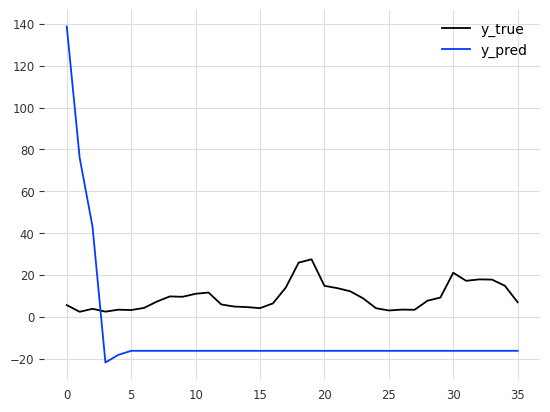

[W 2023-10-28 00:07:14,204] Trial 0 failed with parameters: {'random_state': 9, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse,

mean_squared_error: 1367.4510
rmse: 36.979061919161815
mape: 5.009708982773262
⭐️⭐️ City:  Bình Định


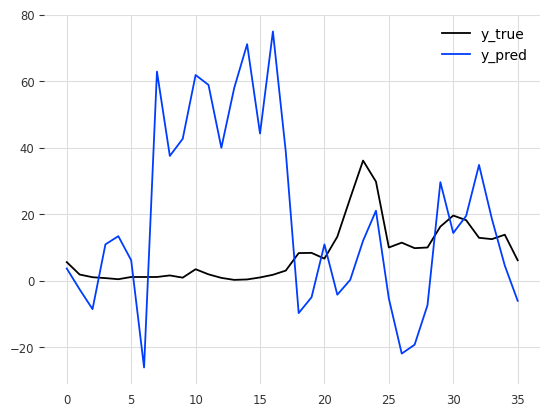

[W 2023-10-28 00:07:14,960] Trial 0 failed with parameters: {'random_state': 25, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 1071.3163
rmse: 32.73096891985489
mape: 22.391457505073436
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  5
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


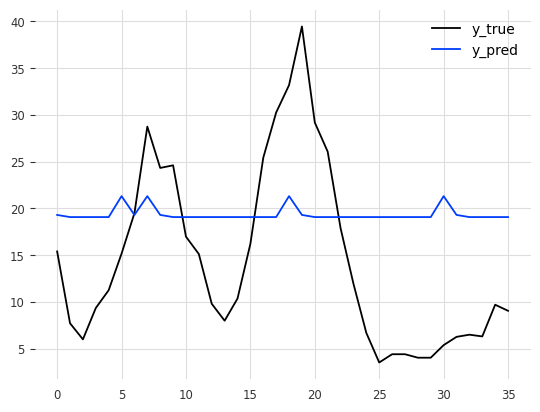

[W 2023-10-28 00:07:15,266] Trial 0 failed with parameters: {'random_state': 10, 'n_estimators': 155, 'max_depth': 2} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse

mean_squared_error: 112.8021
rmse: 10.620833277673283
mape: 1.2406162622550108
⭐️⭐️ City:  BR Vũng Tàu


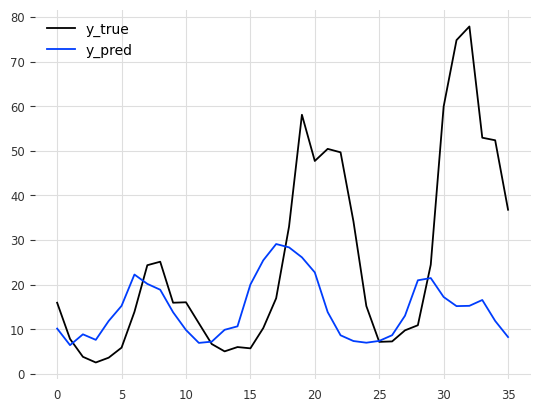

[W 2023-10-28 00:07:15,593] Trial 0 failed with parameters: {'random_state': 6, 'n_estimators': 165, 'max_depth': 11} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse

mean_squared_error: 548.3977
rmse: 23.417892988167132
mape: 0.7341507077013869
⭐️⭐️ City:  Bình Phước


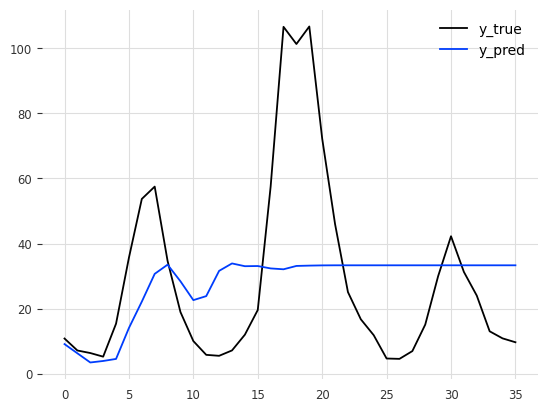

[W 2023-10-28 00:07:15,947] Trial 0 failed with parameters: {'random_state': 34, 'n_estimators': 166, 'max_depth': 7} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse

mean_squared_error: 776.9157
rmse: 27.87320781417165
mape: 1.3865913566512709
⭐️⭐️ City:  Bình Thuận


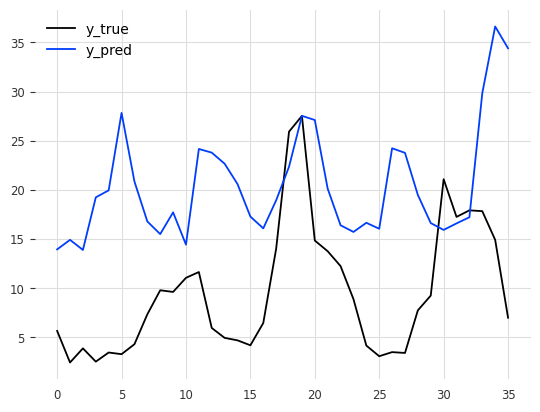

[W 2023-10-28 00:07:16,179] Trial 0 failed with parameters: {'random_state': 3, 'n_estimators': 101, 'max_depth': 6} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse,

mean_squared_error: 175.0687
rmse: 13.231351741704781
mape: 2.252554848631837
⭐️⭐️ City:  Bình Định


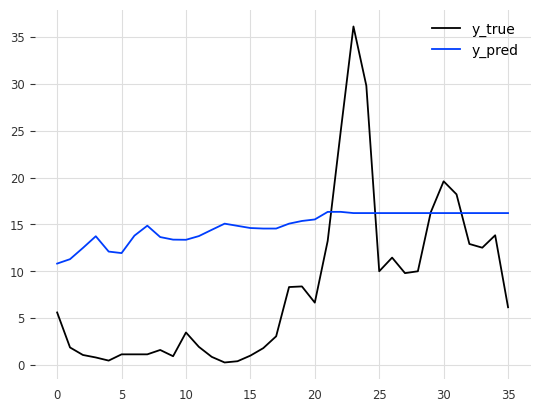

[W 2023-10-28 00:07:16,474] Trial 0 failed with parameters: {'random_state': 21, 'n_estimators': 132, 'max_depth': 15} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 104.7888
rmse: 10.236642036086284
mape: 7.275896988626643
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


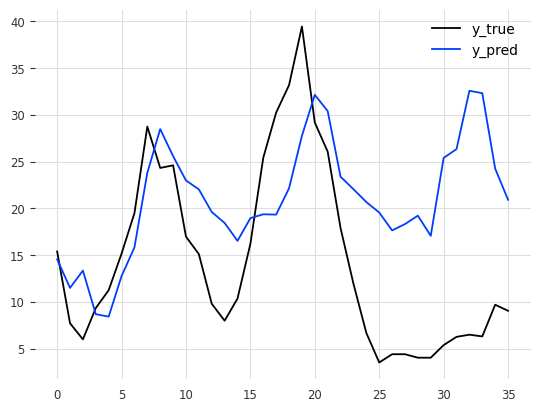

[W 2023-10-28 00:07:16,591] Trial 0 failed with parameters: {'random_state': 10} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 132.9667
rmse: 11.531119094833743
mape: 1.305462112091867
⭐️⭐️ City:  BR Vũng Tàu


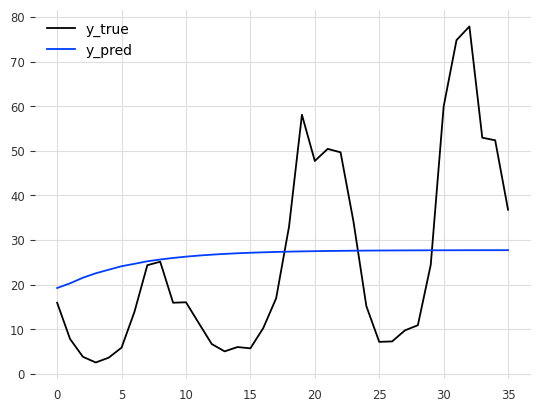

[W 2023-10-28 00:07:16,706] Trial 0 failed with parameters: {'random_state': 20} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 429.7157
rmse: 20.729585370623113
mape: 1.6220652481697955
⭐️⭐️ City:  Bình Phước


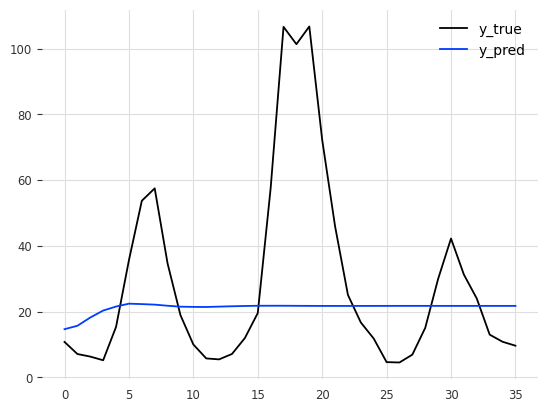

[W 2023-10-28 00:07:16,818] Trial 0 failed with parameters: {'random_state': 4} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate

mean_squared_error: 863.4692
rmse: 29.384846427821643
mape: 1.0580826924809923
⭐️⭐️ City:  Bình Thuận


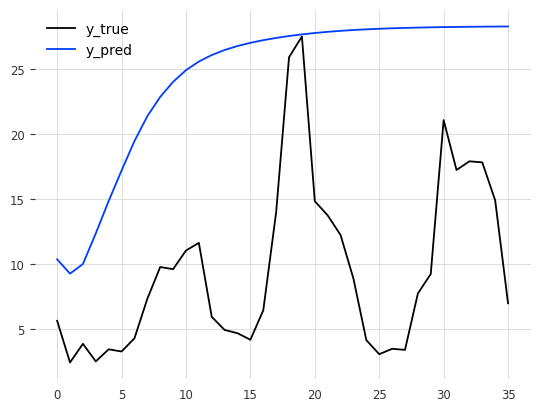

[W 2023-10-28 00:07:16,998] Trial 0 failed with parameters: {'random_state': 40} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 261.4633
rmse: 16.169826351001845
mape: 2.602559005282301
⭐️⭐️ City:  Bình Định


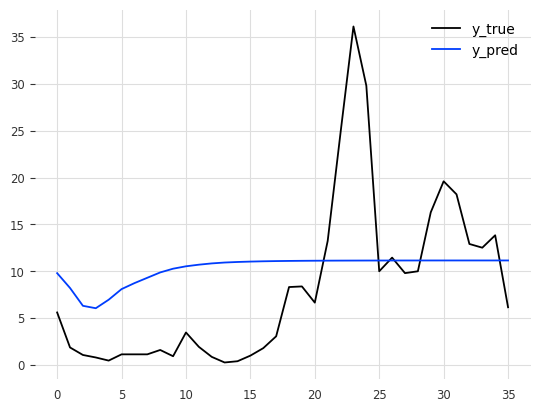

[W 2023-10-28 00:07:17,121] Trial 0 failed with parameters: {'random_state': 20} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 71.6092
rmse: 8.46221951387171
mape: 4.818164261975053
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LightGBMModel
⭐️⭐️ City:  An Giang
⭐️⭐️ City:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước
⭐️⭐️ City:  Bình Thuận
⭐️⭐️ City:  Bình Định
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


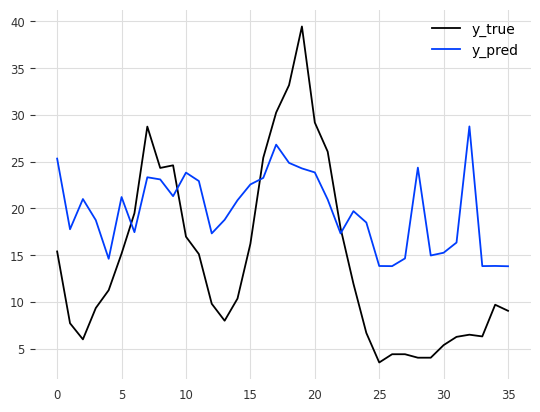

[W 2023-10-28 00:07:21,287] Trial 0 failed with parameters: {'learning_rate': 0.07200776226521305, 'n_estimators': 57, 'max_depth': 15, 'random_state': 588, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 5.967984513388405, 'border_count': 37, 'l2_leaf_reg': 9.16715622237257, 'random_strength': 5.2676089383332485} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid,

mean_squared_error: 89.8704
rmse: 9.480000813667862
mape: 1.07954378605956
⭐️⭐️ City:  BR Vũng Tàu


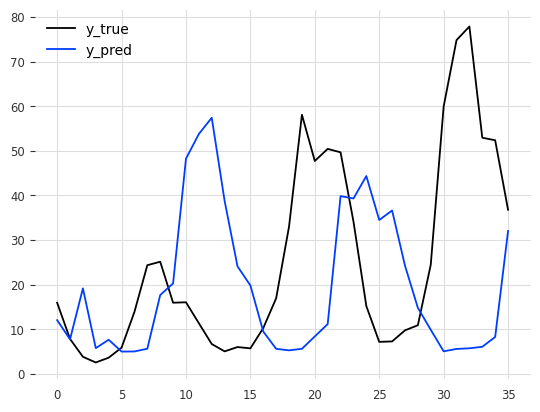

[W 2023-10-28 00:07:21,701] Trial 0 failed with parameters: {'learning_rate': 0.09840552529079996, 'n_estimators': 82, 'max_depth': 8, 'random_state': 455, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 26.58176687721623, 'border_count': 179, 'l2_leaf_reg': 7.430915649089489, 'random_strength': 7.918694769670141} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid,

mean_squared_error: 966.5542
rmse: 31.089454817259256
mape: 1.5442069752316943
⭐️⭐️ City:  Bình Phước


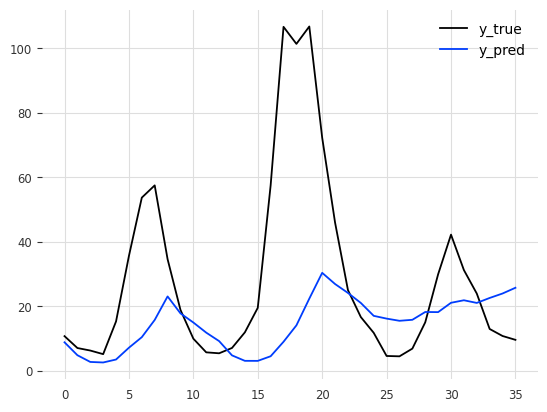

[W 2023-10-28 00:07:22,259] Trial 0 failed with parameters: {'learning_rate': 0.08953449884601318, 'n_estimators': 112, 'max_depth': 5, 'random_state': 541, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 66.65204729993972, 'border_count': 226, 'l2_leaf_reg': 6.709796638749009, 'random_strength': 6.3369740002755} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, loca

mean_squared_error: 996.6451
rmse: 31.569686049295026
mape: 0.713590321428903
⭐️⭐️ City:  Bình Thuận


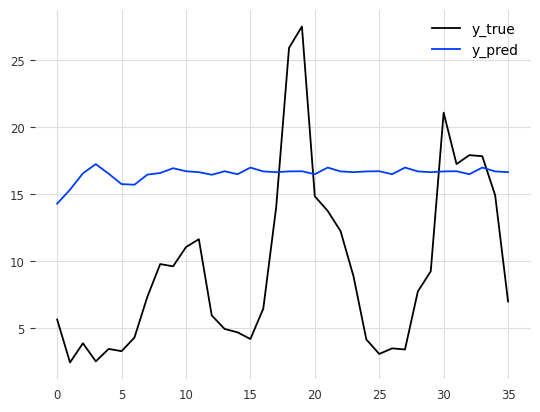

[W 2023-10-28 00:07:22,588] Trial 0 failed with parameters: {'learning_rate': 0.03209627580622722, 'n_estimators': 99, 'max_depth': 6, 'random_state': 498, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 26.888839005608638, 'border_count': 86, 'l2_leaf_reg': 2.2463400271570397, 'random_strength': 3.872175117149418} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid

mean_squared_error: 89.5597
rmse: 9.463596643580013
mape: 1.7350643401043342
⭐️⭐️ City:  Bình Định


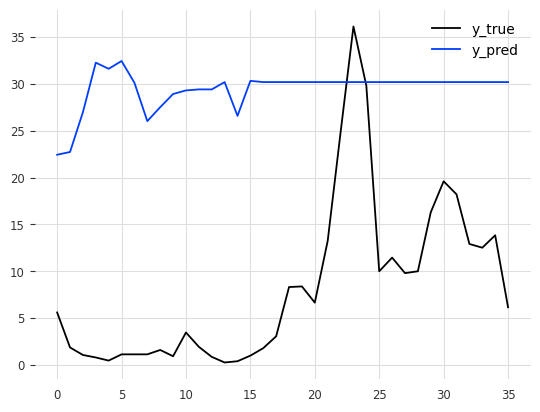

[W 2023-10-28 00:07:24,949] Trial 0 failed with parameters: {'learning_rate': 0.04080543703025059, 'n_estimators': 89, 'max_depth': 12, 'random_state': 382, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 99.8390474545991, 'border_count': 169, 'l2_leaf_reg': 2.322014138964716, 'random_strength': 5.9871054483844475} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid

mean_squared_error: 522.9744
rmse: 22.868632927690058
mape: 16.125076432394007
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


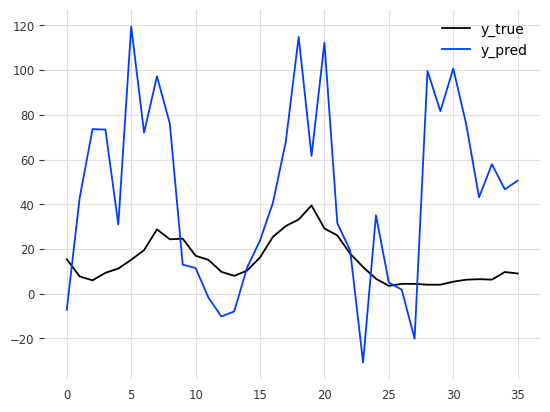

[W 2023-10-28 00:07:25,777] Trial 0 failed with parameters: {'random_state': 29, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 2446.8271
rmse: 49.46541303522303
mape: 4.518907771729799
⭐️⭐️ City:  BR Vũng Tàu


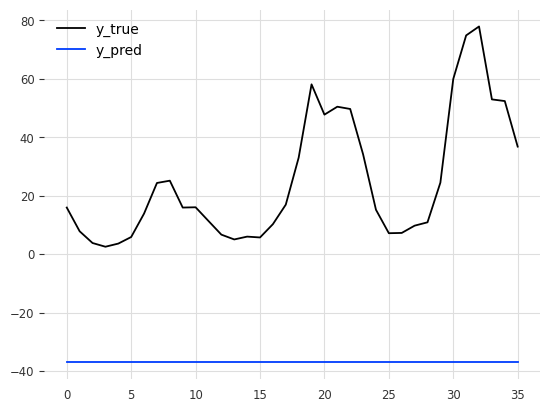

[W 2023-10-28 00:07:26,843] Trial 0 failed with parameters: {'random_state': 1, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse,

mean_squared_error: 4312.5242
rmse: 65.66981191363705
mape: 4.426463447462722
⭐️⭐️ City:  Bình Phước


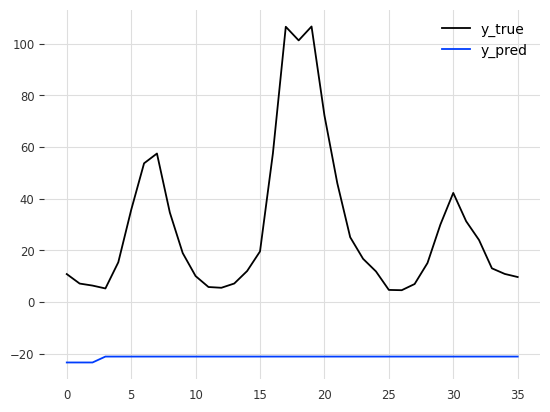

[W 2023-10-28 00:07:27,535] Trial 0 failed with parameters: {'random_state': 8, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse,

mean_squared_error: 3346.9747
rmse: 57.853043696127614
mape: 2.6885242643178207
⭐️⭐️ City:  Bình Thuận


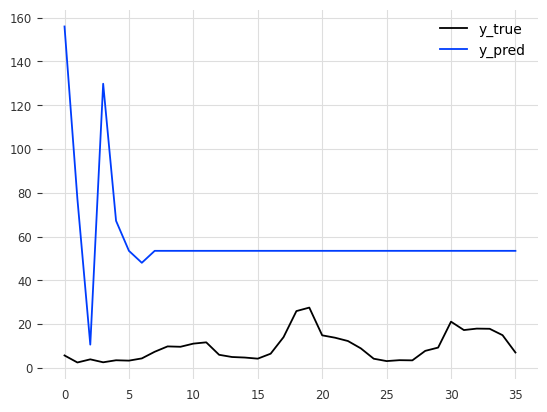

[W 2023-10-28 00:07:28,274] Trial 0 failed with parameters: {'random_state': 13, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 2952.8827
rmse: 54.34043321458014
mape: 9.05489273359647
⭐️⭐️ City:  Bình Định


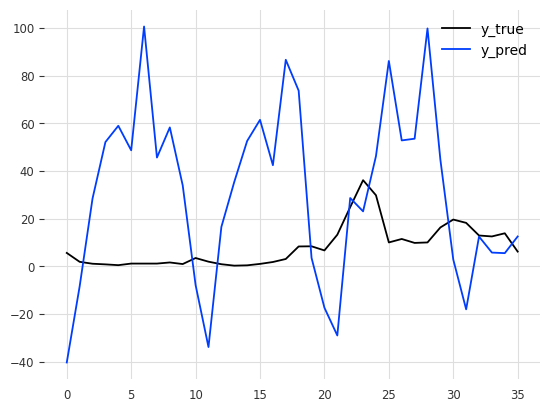

[W 2023-10-28 00:07:29,064] Trial 0 failed with parameters: {'random_state': 37, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 2015.6484
rmse: 44.895973288299224
mape: 25.80216853923254
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  6
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


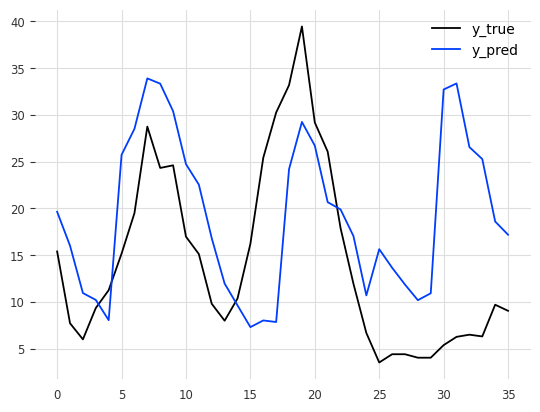

[W 2023-10-28 00:07:29,391] Trial 0 failed with parameters: {'random_state': 21, 'n_estimators': 131, 'max_depth': 10} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 126.4268
rmse: 11.243969163079703
mape: 1.0669782711830686
⭐️⭐️ City:  BR Vũng Tàu


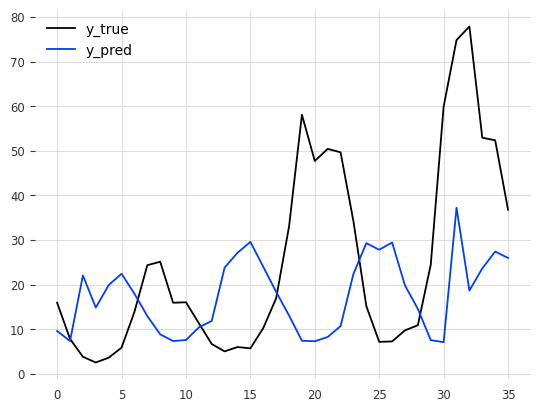

[W 2023-10-28 00:07:29,812] Trial 0 failed with parameters: {'random_state': 16, 'n_estimators': 194, 'max_depth': 11} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 612.9864
rmse: 24.75856272319346
mape: 1.3964372864622294
⭐️⭐️ City:  Bình Phước


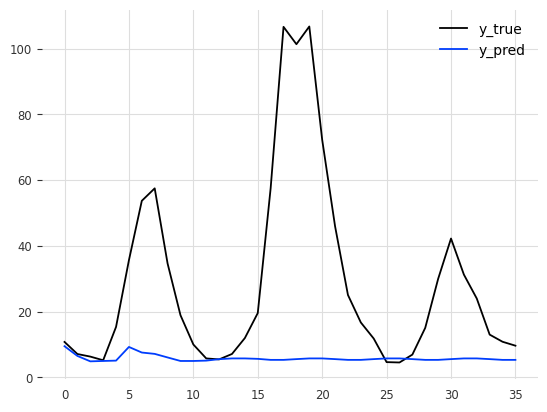

[W 2023-10-28 00:07:29,985] Trial 0 failed with parameters: {'random_state': 4, 'n_estimators': 56, 'max_depth': 4} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, 

mean_squared_error: 1355.9580
rmse: 36.823334693459664
mape: 0.580479624342213
⭐️⭐️ City:  Bình Thuận


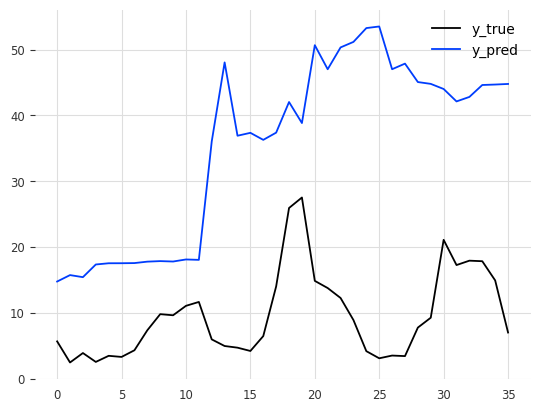

[W 2023-10-28 00:07:30,267] Trial 0 failed with parameters: {'random_state': 19, 'n_estimators': 125, 'max_depth': 10} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, ms

mean_squared_error: 837.5685
rmse: 28.940775448507583
mape: 4.309920231899661
⭐️⭐️ City:  Bình Định


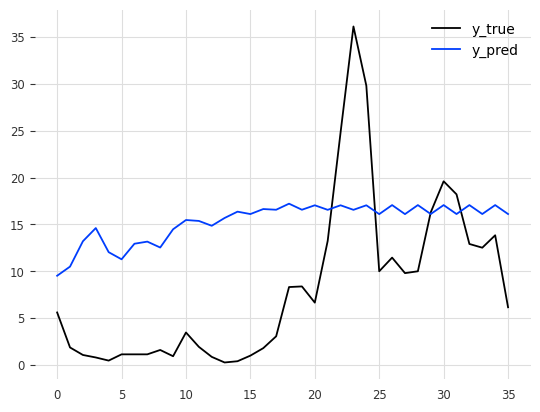

[W 2023-10-28 00:07:30,653] Trial 0 failed with parameters: {'random_state': 0, 'n_estimators': 192, 'max_depth': 13} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse

mean_squared_error: 113.3213
rmse: 10.645249883666224
mape: 7.5737715820281055
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


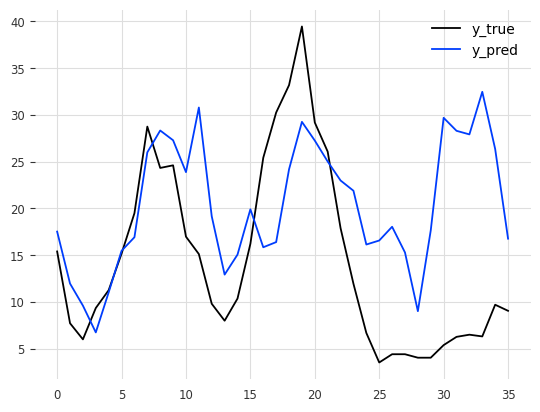

[W 2023-10-28 00:07:30,767] Trial 0 failed with parameters: {'random_state': 2} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate

mean_squared_error: 123.6266
rmse: 11.118750513118723
mape: 1.1581616167012556
⭐️⭐️ City:  BR Vũng Tàu


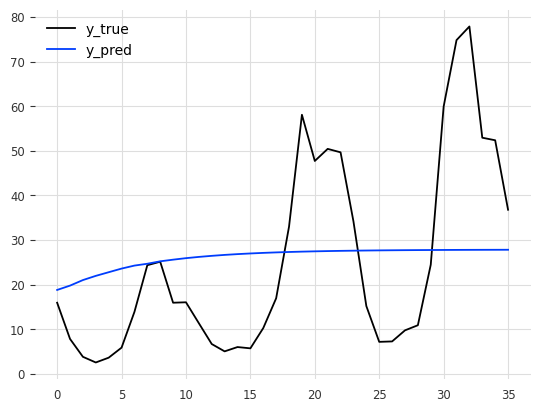

[W 2023-10-28 00:07:30,886] Trial 0 failed with parameters: {'random_state': 23} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 424.5226
rmse: 20.603947044112772
mape: 1.5946279705416588
⭐️⭐️ City:  Bình Phước


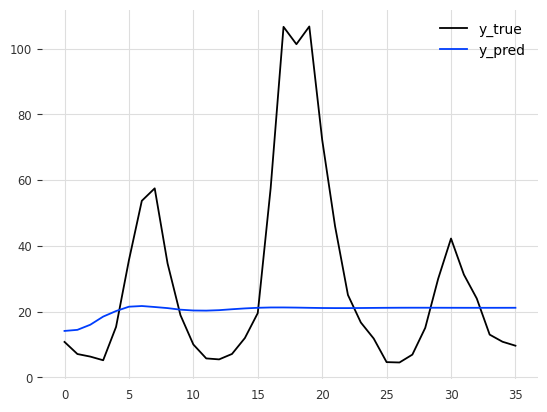

[W 2023-10-28 00:07:31,031] Trial 0 failed with parameters: {'random_state': 22} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 869.1969
rmse: 29.4821460277509
mape: 0.9979389779987559
⭐️⭐️ City:  Bình Thuận


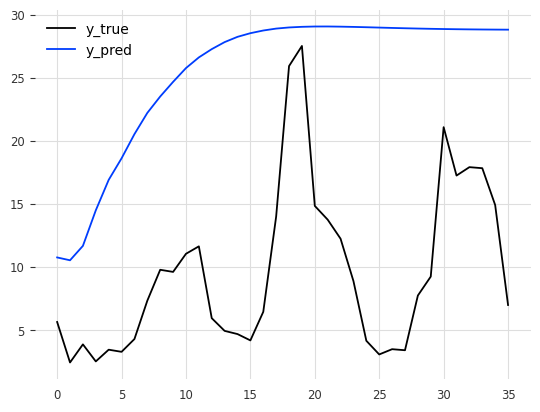

[W 2023-10-28 00:07:31,142] Trial 0 failed with parameters: {'random_state': 14} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 293.1845
rmse: 17.122631621858634
mape: 2.7920745723149127
⭐️⭐️ City:  Bình Định


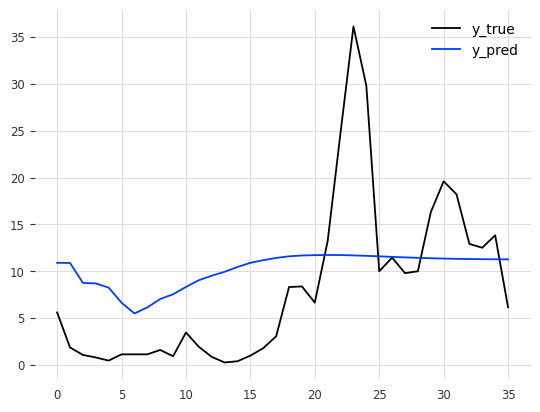

[W 2023-10-28 00:07:31,285] Trial 0 failed with parameters: {'random_state': 19} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluat

mean_squared_error: 65.9155
rmse: 8.118837746131863
mape: 4.554505643917221
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LightGBMModel
⭐️⭐️ City:  An Giang
⭐️⭐️ City:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước
⭐️⭐️ City:  Bình Thuận
⭐️⭐️ City:  Bình Định
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


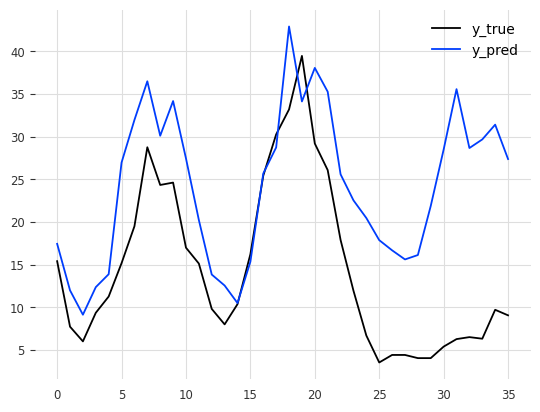

[W 2023-10-28 00:07:33,471] Trial 0 failed with parameters: {'learning_rate': 0.04917447977265884, 'n_estimators': 181, 'max_depth': 10, 'random_state': 649, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 63.008420116610154, 'border_count': 186, 'l2_leaf_reg': 7.593066641087939, 'random_strength': 3.6109407965776814} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_va

mean_squared_error: 153.6340
rmse: 12.39491801862133
mape: 1.325142456338543
⭐️⭐️ City:  BR Vũng Tàu


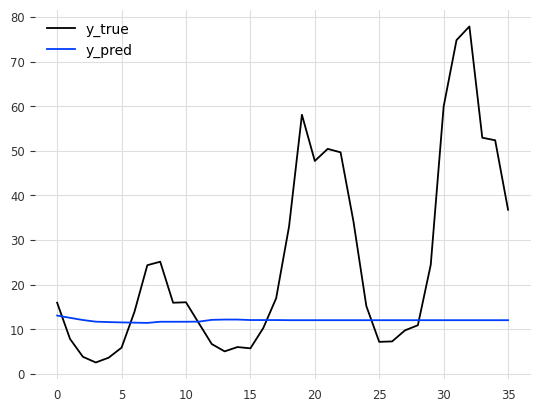

[W 2023-10-28 00:07:33,806] Trial 0 failed with parameters: {'learning_rate': 0.03077730528558658, 'n_estimators': 95, 'max_depth': 3, 'random_state': 374, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 79.55437859003517, 'border_count': 183, 'l2_leaf_reg': 2.3310914933994864, 'random_strength': 5.946686375926954} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, lo

mean_squared_error: 632.7580
rmse: 25.154682444833867
mape: 0.7719562918327942
⭐️⭐️ City:  Bình Phước


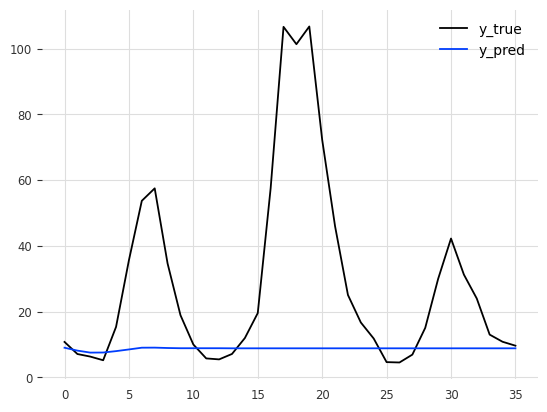

[W 2023-10-28 00:07:33,985] Trial 0 failed with parameters: {'learning_rate': 0.01917894192505275, 'n_estimators': 125, 'max_depth': 2, 'random_state': 550, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 37.88942952128549, 'border_count': 194, 'l2_leaf_reg': 1.321506181008057, 'random_strength': 4.937707212458621} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid

mean_squared_error: 1228.4966
rmse: 35.04991539201235
mape: 0.556894791028292
⭐️⭐️ City:  Bình Thuận


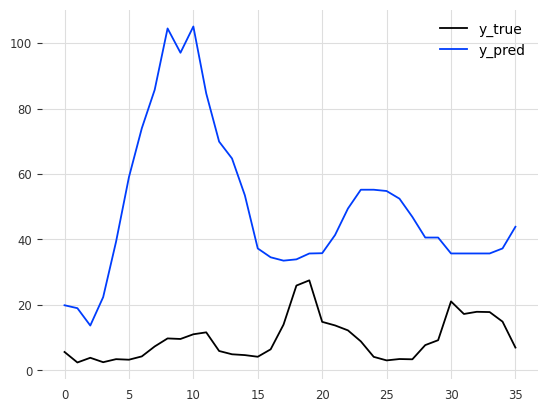

[W 2023-10-28 00:07:43,084] Trial 0 failed with parameters: {'learning_rate': 0.022637094404290143, 'n_estimators': 102, 'max_depth': 15, 'random_state': 45, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 15.086561235225602, 'border_count': 23, 'l2_leaf_reg': 6.729998143767337, 'random_strength': 8.331518560402193} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, l

mean_squared_error: 2193.2803
rmse: 46.83247018406744
mape: 6.673741962102963
⭐️⭐️ City:  Bình Định


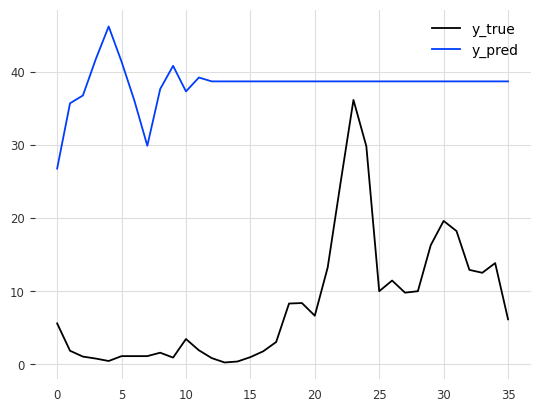

[W 2023-10-28 00:07:44,179] Trial 0 failed with parameters: {'learning_rate': 0.05345434863180914, 'n_estimators': 130, 'max_depth': 9, 'random_state': 270, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 47.966731411345044, 'border_count': 30, 'l2_leaf_reg': 6.4783414067691805, 'random_strength': 2.685556317404425} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, l

mean_squared_error: 984.3675
rmse: 31.37463182166561
mape: 21.78235739944117
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


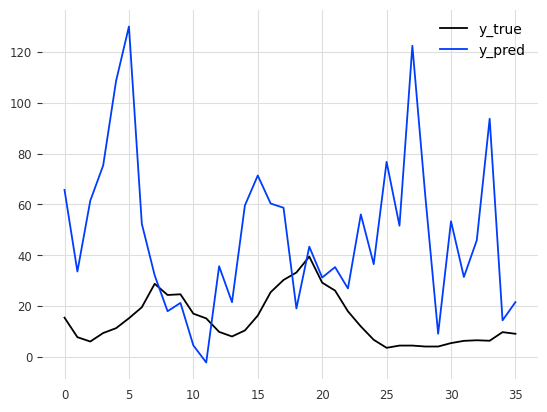

[W 2023-10-28 00:07:45,112] Trial 0 failed with parameters: {'random_state': 15, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 2331.0732
rmse: 48.28118877581905
mape: 4.902775186654829
⭐️⭐️ City:  BR Vũng Tàu


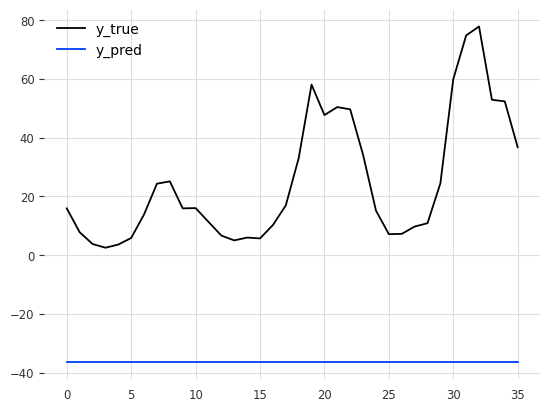

[W 2023-10-28 00:07:45,833] Trial 0 failed with parameters: {'random_state': 0, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse,

mean_squared_error: 4248.5089
rmse: 65.18058706402019
mape: 4.378543589388688
⭐️⭐️ City:  Bình Phước


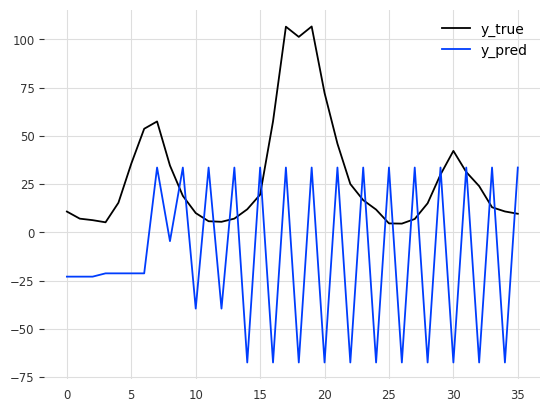

[W 2023-10-28 00:07:46,634] Trial 0 failed with parameters: {'random_state': 20, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 4420.8370
rmse: 66.48937492076982
mape: 3.3771459666300996
⭐️⭐️ City:  Bình Thuận


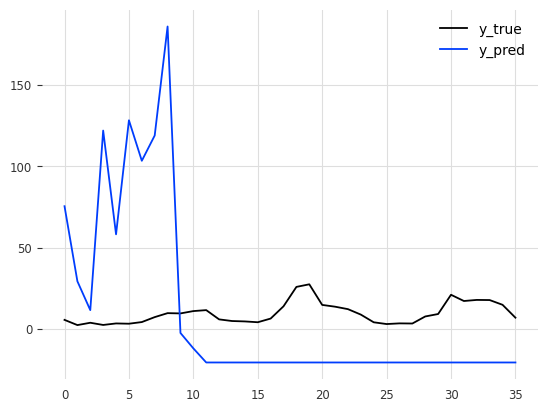

[W 2023-10-28 00:07:47,411] Trial 0 failed with parameters: {'random_state': 15, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 3311.7438
rmse: 57.54775224475686
mape: 7.770461829929875
⭐️⭐️ City:  Bình Định


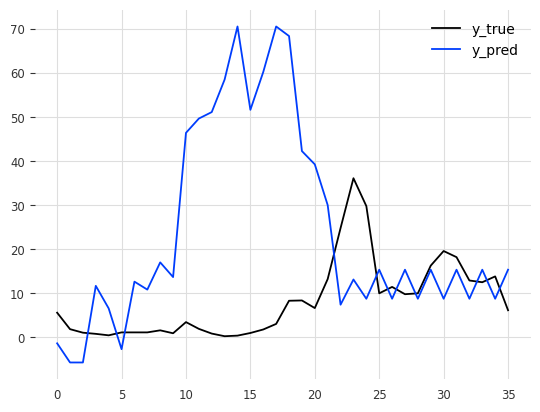

[W 2023-10-28 00:07:48,289] Trial 0 failed with parameters: {'random_state': 40, 'likelihood': 'quantile'} because of the following error: TypeError('cannot unpack non-iterable int object').
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/847928226.py", line 37, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/374762962.py", line 225, in objective
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_36494/3248126458.py", line 12, in output_prediction_for_location
    model, y_true, prediction_inverse, mse, mae, rmse

mean_squared_error: 949.9814
rmse: 30.8217689100771
mape: 19.52972453564159


In [912]:
#########################
# Main cell for optimize ML algorithm
#########################
# Hai thuật toán này chưa chạy đc nhe, nên đừng truyền vô mảng để nó chạy nhoé!
# "PoissonRegressor"
# "SVMRBF"

model_name_list = [
     "RandomForest",
     "LinearRegressionModel",
     "LightGBMModel",
     "CatBoostModel",
     "XGBModel",
    
]


# Lưu thông tin traceback study và error city trong quá trình optimize
l_study_city ={}
l_errCity =[]

if __name__ == '__main__':
  for nstep in range(1,args.n_predicted_period_months+1):
    print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep: ",nstep)
    lags_by_nstep = args.look_back + nstep - 1
    lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
    lags_past_covariates_in_str = str(-lags_by_nstep+2)+","+str(-lags_by_nstep+1)+","+str(-lags_by_nstep)
    for model_name in model_name_list: 
      print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name: ",model_name)
      best_param = pd.DataFrame()
      for city_index in range(len(cities)):
        print("⭐️⭐️ City: ",cities[city_index])
        # Use Tree-structured Parzen Estimator sampler to minimise RMSE
        sampler = optuna.samplers.TPESampler()
        study = optuna.create_study(sampler=sampler, direction='minimize', study_name = model_name)
        # truyền multiple param vào trong biến trial
        obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
        try:
          # Optimise over 100 trials
          study.optimize(obj_func, n_trials=args.ntry, n_jobs=args.njob)

          # Print results
          print("Study statistics for : ")
          print("  Number of finished trials: ", len(study.trials))
          print("Best trial of city: ",cities[city_index])

          best_trial = study.best_trial
          # lưu best param vào trong biến toàn cục

          if model_name == "LinearRegressionModel":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'LinearRegressionModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'random_state':best_trial.params['random_state'],
                                })
          elif model_name == 'XGBModel':
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'XGBModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'random_state':best_trial.params['random_state'],
                                'likelihood': best_trial.params['likelihood'],
                                })
          elif model_name == "LightGBMModel":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'LightGBMModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags': lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'multi_models': best_trial.params['multi_models'],
                                'num_leaves': best_trial.params['num_leaves'], 
                                'feature_fraction': best_trial.params['feature_fraction'], 
                                'min_child_samples': best_trial.params['min_child_samples'], 
                                'lambda_l1': best_trial.params['lambda_l1'], 
                                'lambda_l2': best_trial.params['lambda_l2'], 
                                'likelihood': best_trial.params['likelihood'], 
                                'learning_rate': best_trial.params['learning_rate']
                                })
          elif model_name == "CatBoostModel":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'CatBoost',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'likelihood': best_trial.params['likelihood'],
                                'learning_rate': best_trial.params['learning_rate'],
                                'n_estimators': best_trial.params['n_estimators'],
                                'max_depth': best_trial.params['max_depth'],
                                'bagging_temperature': best_trial.params['bagging_temperature'],
                                'l2_leaf_reg': best_trial.params['l2_leaf_reg'],
                                'random_strength':best_trial.params['random_strength'],
                                })
          elif model_name == "RandomForest":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'RandomForest',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'n_estimators': best_trial.params['n_estimators'],
                                'max_depth': best_trial.params['max_depth'],
                                'random_state':best_trial.params['random_state'],
                                })
          elif model_name == "SVMRBF":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'RandomForest',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'random_state':best_trial.params['random_state'],
                                'kernel': 'rbf',
                                'probability': True,
                                })
          elif model_name == "PoissonRegressor":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'RandomForest',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'max_iter':best_trial.params['max_iter'],
                                })
          # file_path = 'opt_results/opt_res_ml_26102023/261023_DF_opt_hyperparam_'+ model_name + '_'+str(nstep)+'-nstep.xlsx'
          folder_path = f'opt_results/opt_res_ml_26102023/{model_name}/'
          file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
          if(os.path.isfile(file_path)):
              with pd.ExcelWriter(file_path,mode="a",engine="openpyxl",if_sheet_exists="overlay") as writer:
                  one_city_param.to_excel(writer, header=None, startrow=city_index+1,index=False)
          else:
              if(not (os.path.isdir(folder_path))):
                os.mkdir(folder_path)
              with pd.ExcelWriter(file_path,engine="openpyxl") as writer:
                  one_city_param.to_excel(writer, startrow=city_index,index=False)
        except:# có error thì lưu vào l_errCity để check lại sau 
          l_errCity.append(cities[city_index])
          #send_to_telegram(f'Tỉnh bị lỗi trong quá trình optimize bằng model {model_name}: {cities[city_index]}')

In [913]:
# send_to_telegram("Chạy xong optimize rùiii!!Vô check thuiii!!!" )